In [3]:
import numpy as np
import re
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
# Arial 7pt
plt.rc('font', family='Arial', size=7)
mpl.rcParams['figure.dpi'] = 300  # 원하는 DPI 값



In [1]:
from rdkit import Chem
from rdkit.Chem import AllChem

# 1. Create a molecule from a SMILES string (example: ethanol)
mol = Chem.MolFromSmiles('CCO')

# 2. Add explicit hydrogens
mol = Chem.AddHs(mol)

# 3. Generate 3D coordinates
AllChem.EmbedMolecule(mol)

# 4. (Optional) Optimize geometry with UFF or MMFF
AllChem.UFFOptimizeMolecule(mol)
# or: AllChem.MMFFOptimizeMolecule(mol)

# 5. Write out to an XYZ file
Chem.MolToXYZFile(mol, 'molecule.xyz')
print("Saved molecule.xyz")


Saved molecule.xyz


In [ ]:
# 정규 표현식으로 데이터 추출
layer_pattern = re.compile(r'Layer: (\d+)')
relaxation_pattern = re.compile(r'Relaxation: (\w+)')

def visualize_metric_result(text_data, property_name, metric, show_relaxation=['X', 'XR']):
    temp_name = property_name.replace("(","\(").replace(")","\)")
    # pattern = rf'Property: {temp_name} \| {metric}: ([\d\.]+) ± ([\d\.]+)'
    pattern = rf'Property: {temp_name} \| {metric}: ([\d\.]+(?:e[-+]?\d+)?) ± ([\d\.]+(?:e[-+]?\d+)?)'
    pattern = rf'Property: {temp_name} \| {metric}: ([\d\.]+(?:e[-+]?\d+)?) ± ([\d\.]+(?:e[-+]?\d+)?)'

    property_pattern = re.compile(pattern)
    # 새로운 데이터 리스트
    data = []

    # 레이어 및 릴랙세이션 상태별로 데이터 추출
    layer = None
    relaxation = None

    lines = text_data.split("\n")
    for line in lines:
        layer_match = layer_pattern.match(line)
        relaxation_match = relaxation_pattern.match(line)
        property_match = property_pattern.match(line)

        if layer_match:
            layer = int(layer_match.group(1))
        elif relaxation_match:
            relaxation = relaxation_match.group(1)
        elif property_match and layer is not None and relaxation is not None:
            mae = float(property_match.group(1))
            std = float(property_match.group(2))
            data.append((layer, relaxation, mae, std))

    # 새로운 데이터프레임 생성
    df_corrected = pd.DataFrame(data, columns=["Layer", "Relaxation", "METRIC", "STD"])

    # 그래프 다시 생성
    plt.figure(figsize=(3.6, 2.4))
    for relaxation in df_corrected["Relaxation"].unique():
        if relaxation in show_relaxation:
            sub_df = df_corrected[df_corrected["Relaxation"] == relaxation]
            # size 1.5, thickness 1.5
            plt.errorbar(sub_df["Layer"], sub_df["METRIC"], yerr=sub_df["STD"], fmt='-o', label=f"Relaxation: {relaxation}", capsize=1.5,  markersize=1.5, elinewidth=0.5, capthick=0.5, linewidth=1.0)

    plt.xlabel("Layer")
    plt.ylabel(f"{property_name} | {metric}")
    # plt.title(f"Eg(eV) | MAE vs Layer for Different Relaxation Conditions")
    # no top and right axis
    plt.gca().spines['top'].set_visible(False)
    plt.gca().spines['right'].set_visible(False)
    plt.legend(frameon=False)
    # plt.grid(True)
    # plt.show()
    return df_corrected

In [6]:
# 정규 표현식으로 데이터 추출
layer_pattern = re.compile(r'Layer: (\d+)')
relaxation_pattern = re.compile(r'Relaxation: (\w+)')

def visualize_metric_result(text_data, property_name, metric, show_relaxation=['X', 'XR']):
    temp_name = property_name.replace("(","\(").replace(")","\)")
    # pattern = rf'Property: {temp_name} \| {metric}: ([\d\.]+) ± ([\d\.]+)'
    pattern = rf'Property: {temp_name}(.*?) \| {metric}: ([\d\.]+(?:e[-+]?\d+)?) ± ([\d\.]+(?:e[-+]?\d+)?)'
    # pattern = rf'Property: {temp_name} \| ([\w]+): ([\d\.]+(?:e[-+]?\d+)?) ± ([\d\.]+(?:e[-+]?\d+)?)'
    property_pattern = re.compile(pattern)
    # 새로운 데이터 리스트
    data = []

    # 레이어 및 릴랙세이션 상태별로 데이터 추출
    layer = None
    relaxation = None

    lines = text_data.split("\n")
    for line in lines:
        layer_match = layer_pattern.match(line)
        relaxation_match = relaxation_pattern.match(line)
        property_match = property_pattern.match(line)

        if layer_match:
            layer = int(layer_match.group(1))
        elif relaxation_match:
            relaxation = relaxation_match.group(1)
        elif property_match and layer is not None and relaxation is not None:
            mae = float(property_match.group(2))
            std = float(property_match.group(3))
            data.append((layer, relaxation, mae, std))

    # 새로운 데이터프레임 생성
    df_corrected = pd.DataFrame(data, columns=["Layer", "Relaxation", "METRIC", "STD"])

    # 그래프 다시 생성
    plt.figure(figsize=(3.6, 2.4))
    for relaxation in df_corrected["Relaxation"].unique():
        if relaxation in show_relaxation:
            sub_df = df_corrected[df_corrected["Relaxation"] == relaxation]
            # size 1.5, thickness 1.5
            plt.errorbar(sub_df["Layer"], sub_df["METRIC"], yerr=sub_df["STD"], fmt='-o', label=f"Relaxation: {relaxation}", capsize=1.5,  markersize=1.5, elinewidth=0.5, capthick=0.5, linewidth=1.0)

    plt.xlabel("Layer")
    plt.ylabel(f"{property_name} | {metric}")
    # plt.title(f"Eg(eV) | MAE vs Layer for Different Relaxation Conditions")
    # no top and right axis
    plt.gca().spines['top'].set_visible(False)
    plt.gca().spines['right'].set_visible(False)
    plt.legend(frameon=False)
    # plt.grid(True)
    # plt.show()
    return df_corrected

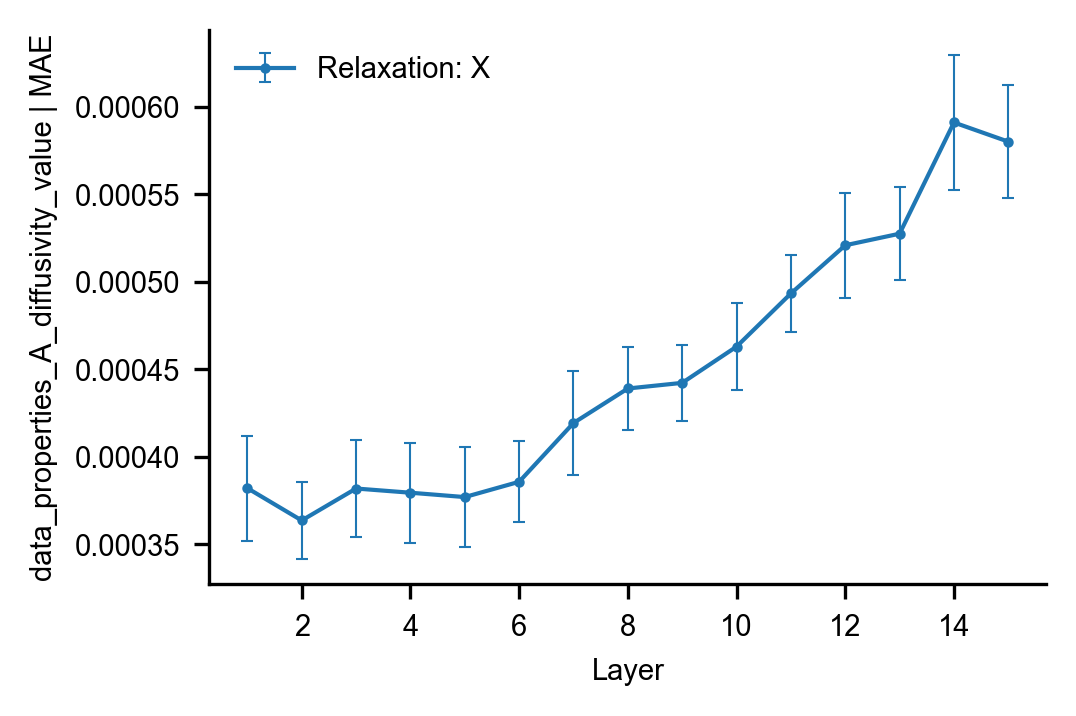

In [8]:

with open('/home/lucky/Projects/ion_conductivity/feat/output/output_MPContribs_armorphous_diffusivity_relaxed_decode.txt', 'r') as f:
    text_data = f.read()
visualize_metric_result(text_data, "data_properties_A_diffusivity_value", "MAE", show_relaxation=['X'])
plt.savefig("figures/output_MPContribs_armorphous_diffusivity_relaxed_decode_data_properties_A_diffusivity_value_MAE.png", dpi=300)
# plt.ylim(0, 0.001)

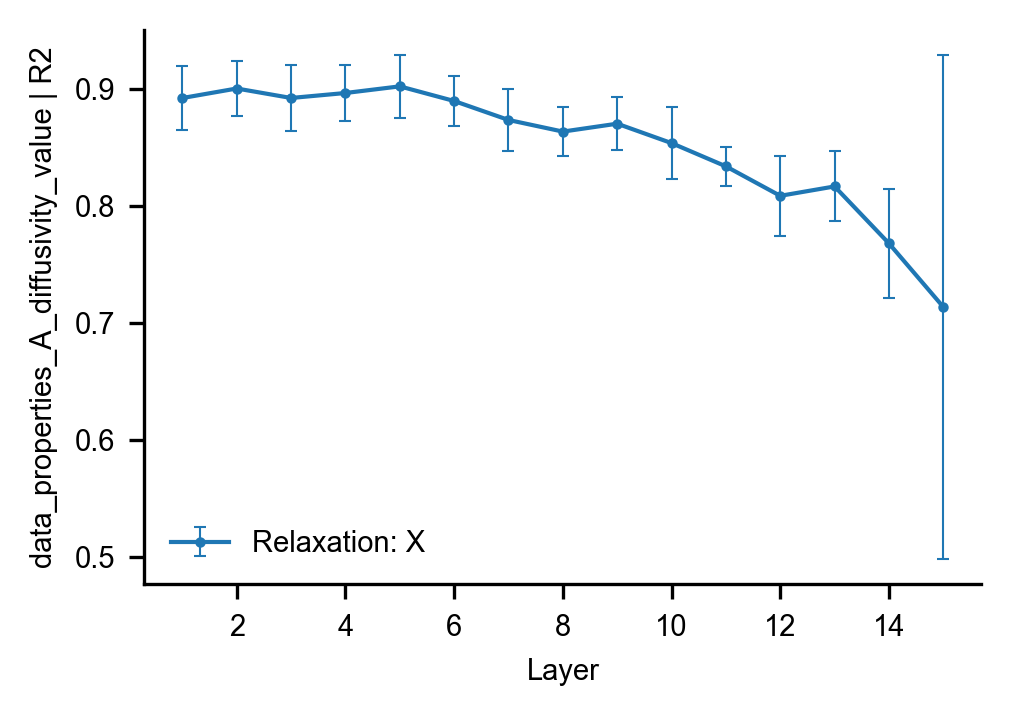

In [7]:

with open('/home/lucky/Projects/ion_conductivity/feat/output/output_MPContribs_armorphous_diffusivity_relaxed_decode.txt', 'r') as f:
    text_data = f.read()
visualize_metric_result(text_data, "data_properties_A_diffusivity_value", "R2", show_relaxation=['X'])
plt.savefig("figures/output_MPContribs_armorphous_diffusivity_relaxed_decode_data_properties_A_diffusivity_value_R2.png", dpi=300)
# plt.ylim(0, 0.001)

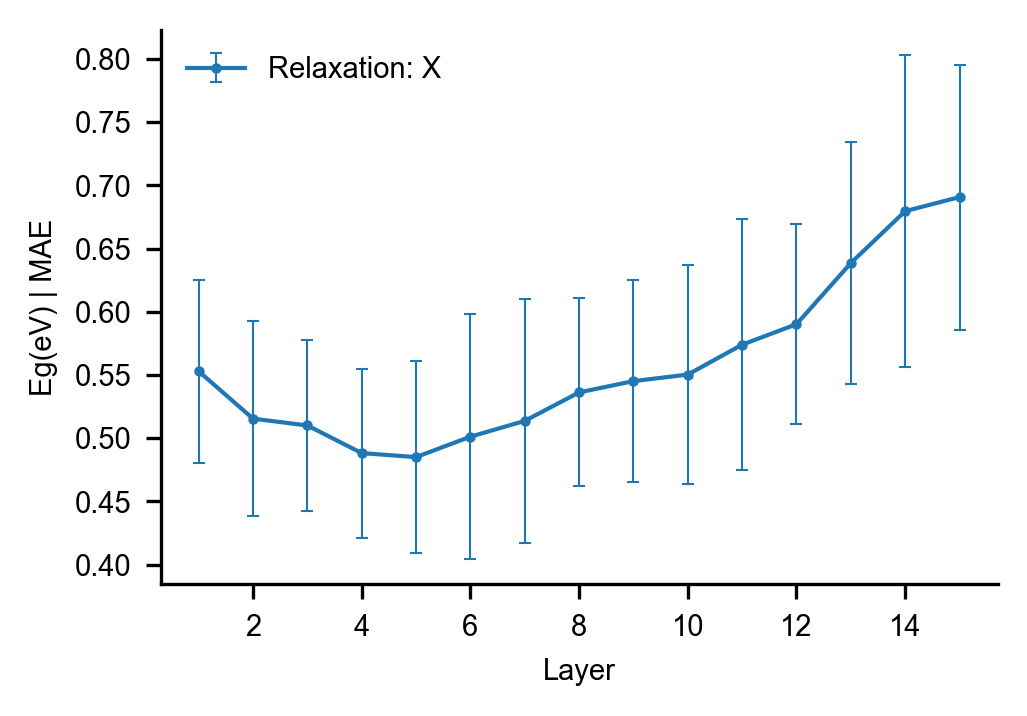

In [8]:

with open('/home/lucky/Projects/ion_conductivity/feat/output/output_Exp_relaxed.txt', 'r') as f:
    text_data = f.read()
visualize_metric_result(text_data, "Eg(eV)", "MAE", show_relaxation=['X'])
plt.savefig("figures/output_Exp_relaxed_Eg(eV)_MAE.png", dpi=300)

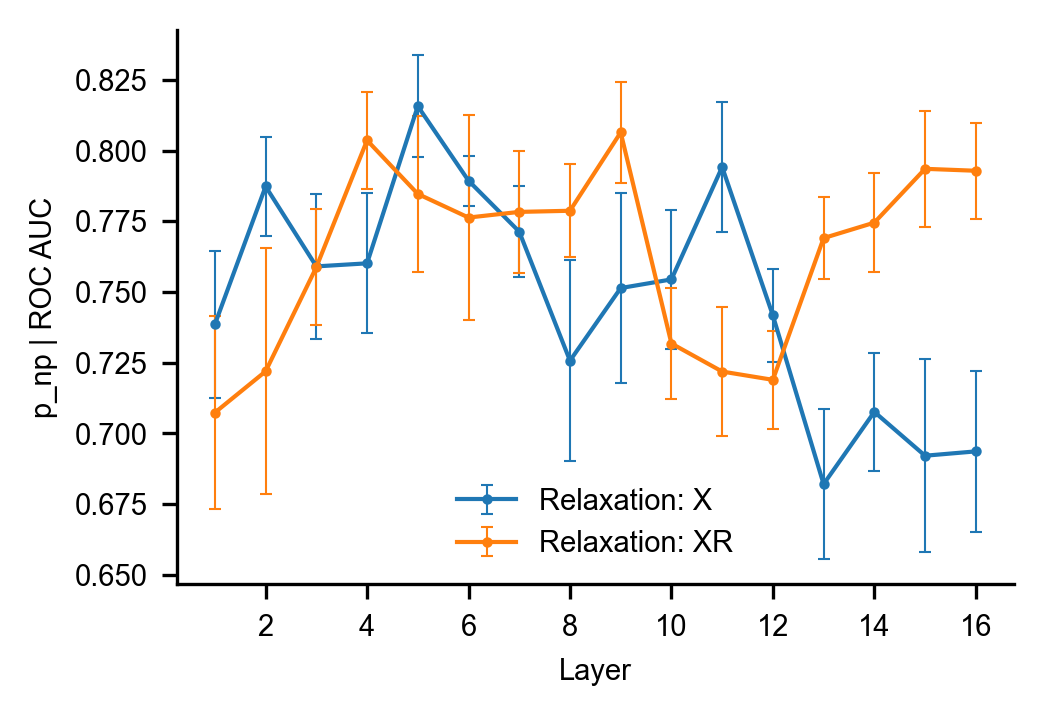

In [50]:
with open('/home/lucky/Projects/ion_conductivity/feat/output/output_BBBP_dataset_relaxed.txt', 'r') as f:
    text_data = f.read()
visualize_metric_result(text_data, "p_np", "ROC AUC")
plt.savefig("figures/output_BBBP_dataset_relaxed_p_np_ROC_AUC.png", dpi=300)

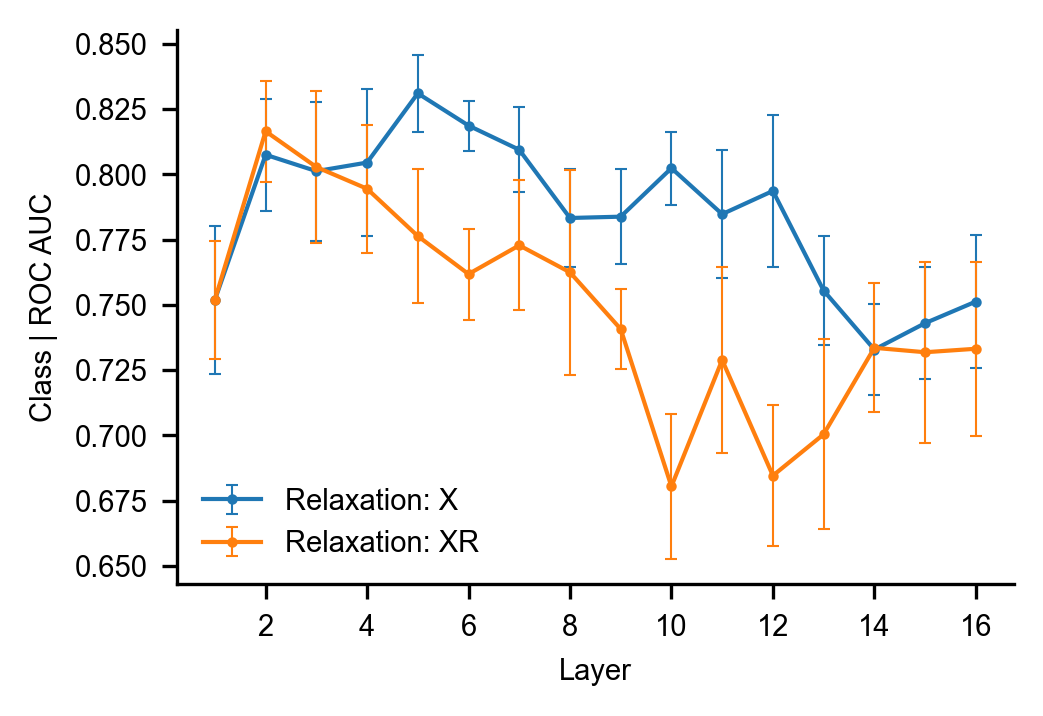

In [51]:
with open('/home/lucky/Projects/ion_conductivity/feat/output/output_BACE_dataset_relaxed.txt', 'r') as f:
    text_data = f.read()
visualize_metric_result(text_data, "Class", "ROC AUC")
plt.savefig("figures/output_BACE_dataset_relaxed_Class_ROC_AUC.png", dpi=300)

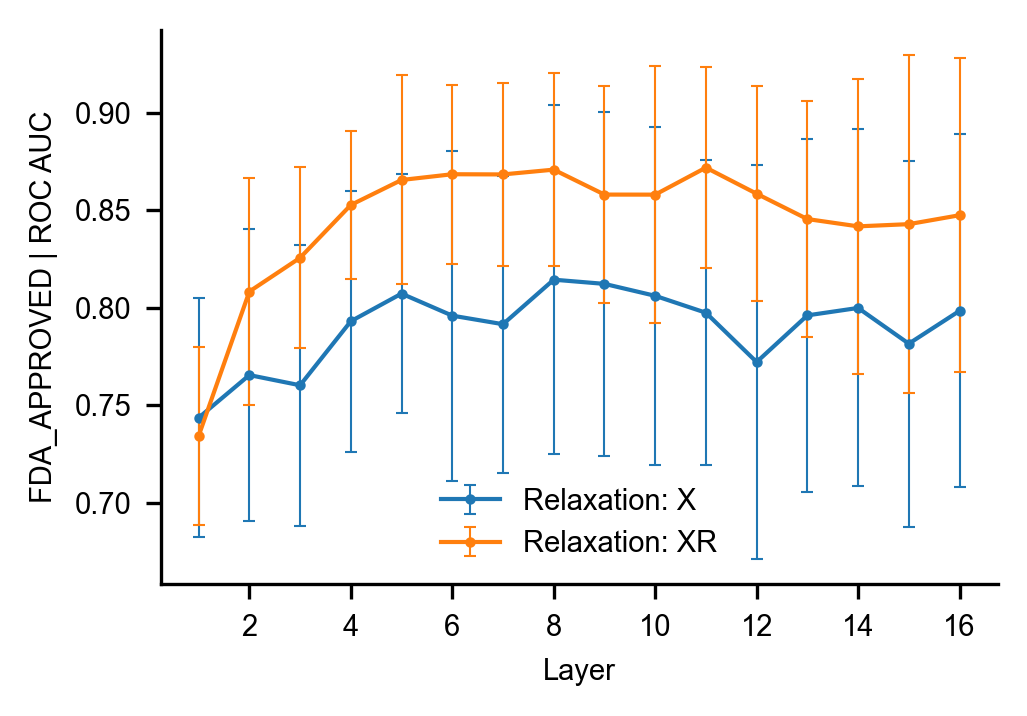

In [52]:
with open('/home/lucky/Projects/ion_conductivity/feat/output/output_ClinTox_dataset_relaxed.txt', 'r') as f:
    text_data = f.read()
visualize_metric_result(text_data, "FDA_APPROVED", "ROC AUC")
plt.savefig("figures/output_ClinTox_dataset_relaxed_FDA_APPROVED_ROC_AUC.png", dpi=300)

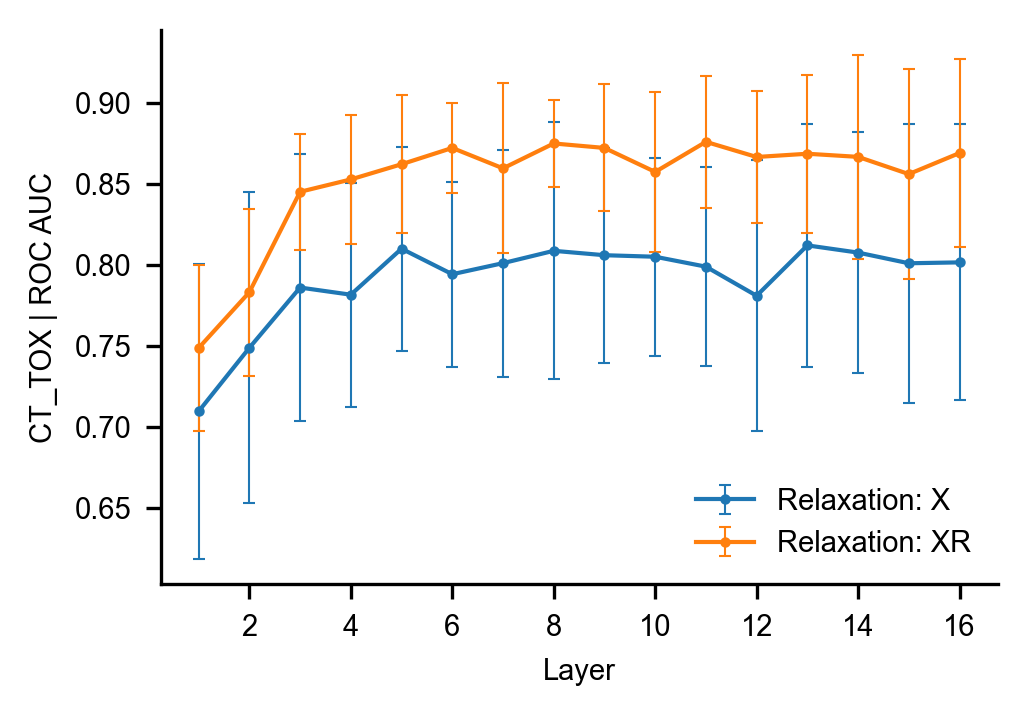

In [53]:
with open('/home/lucky/Projects/ion_conductivity/feat/output/output_ClinTox_dataset_relaxed.txt', 'r') as f:
    text_data = f.read()
visualize_metric_result(text_data, "CT_TOX", "ROC AUC")
plt.savefig("figures/output_ClinTox_dataset_relaxed_CT_TOX_ROC_AUC.png", dpi=300)

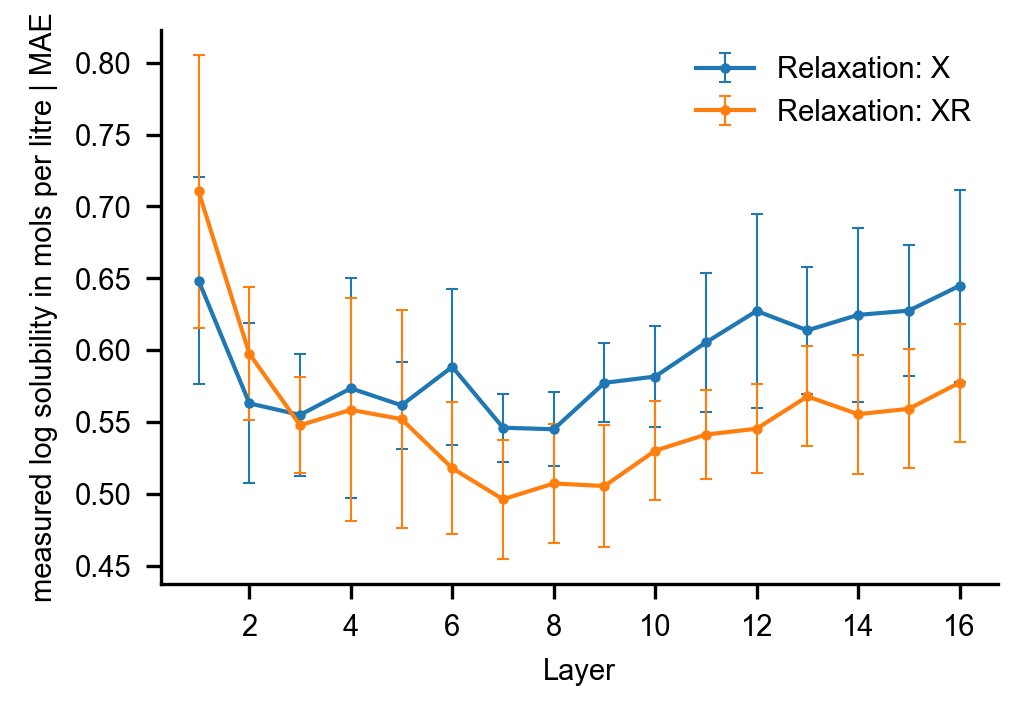

In [54]:
with open('/home/lucky/Projects/ion_conductivity/feat/output/output_ESOL_dataset_relaxed.txt', 'r') as f:
    text_data = f.read()
visualize_metric_result(text_data, "measured log solubility in mols per litre", "MAE")
plt.savefig("figures/output_ESOL_dataset_relaxed_measured log solubility in mols per litre_MAE.png", dpi=300)

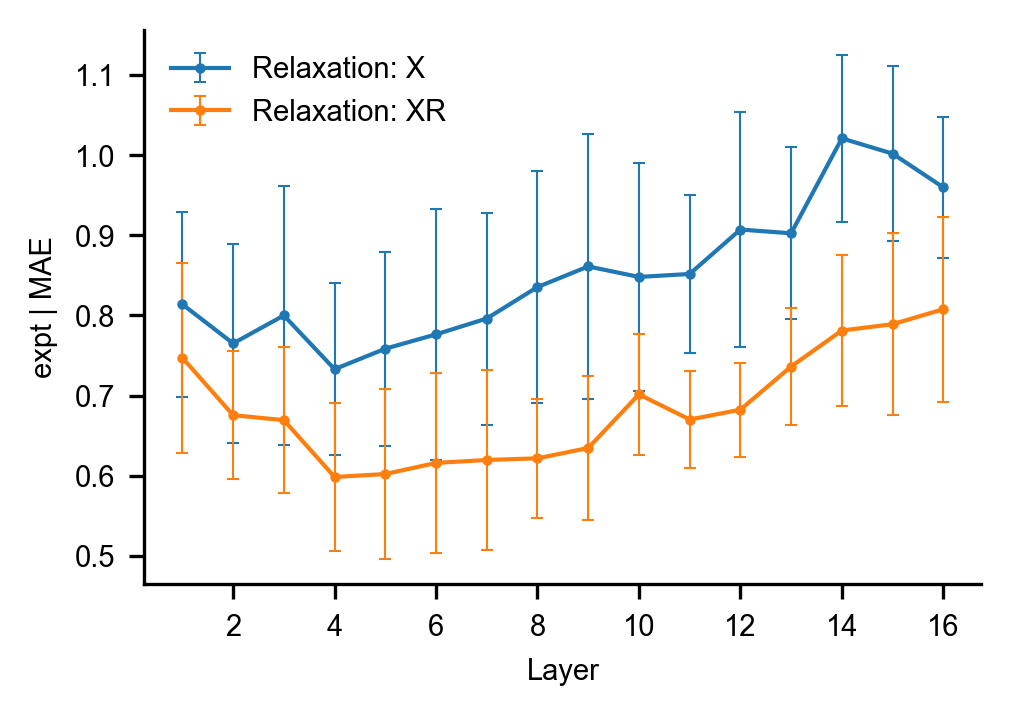

In [55]:
with open('/home/lucky/Projects/ion_conductivity/feat/output/output_FreeSolv_dataset_relaxed.txt', 'r') as f:
    text_data = f.read()
visualize_metric_result(text_data, "expt", "MAE")
plt.savefig("figures/output_FreeSolv_dataset_relaxed_expt_MAE.png", dpi=300)

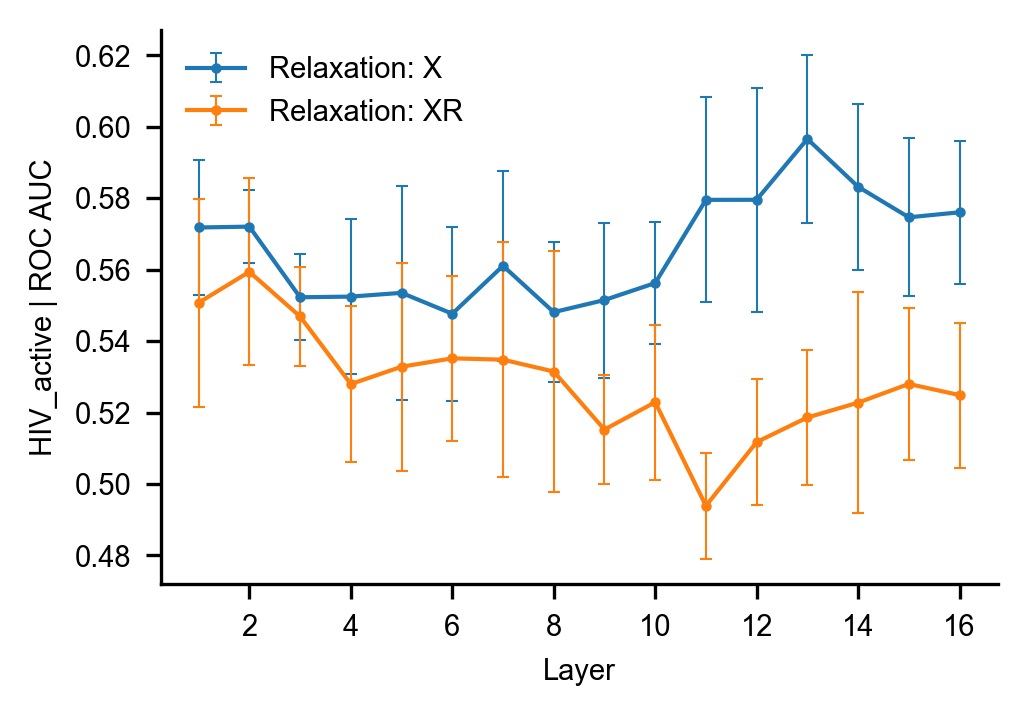

In [56]:
with open('/home/lucky/Projects/ion_conductivity/feat/output/output_HIV_dataset_relaxed.txt', 'r') as f:
    text_data = f.read()
visualize_metric_result(text_data, "HIV_active", "ROC AUC")
plt.savefig("figures/output_HIV_dataset_relaxed_HIV_active_ROC AUC.png", dpi=300)

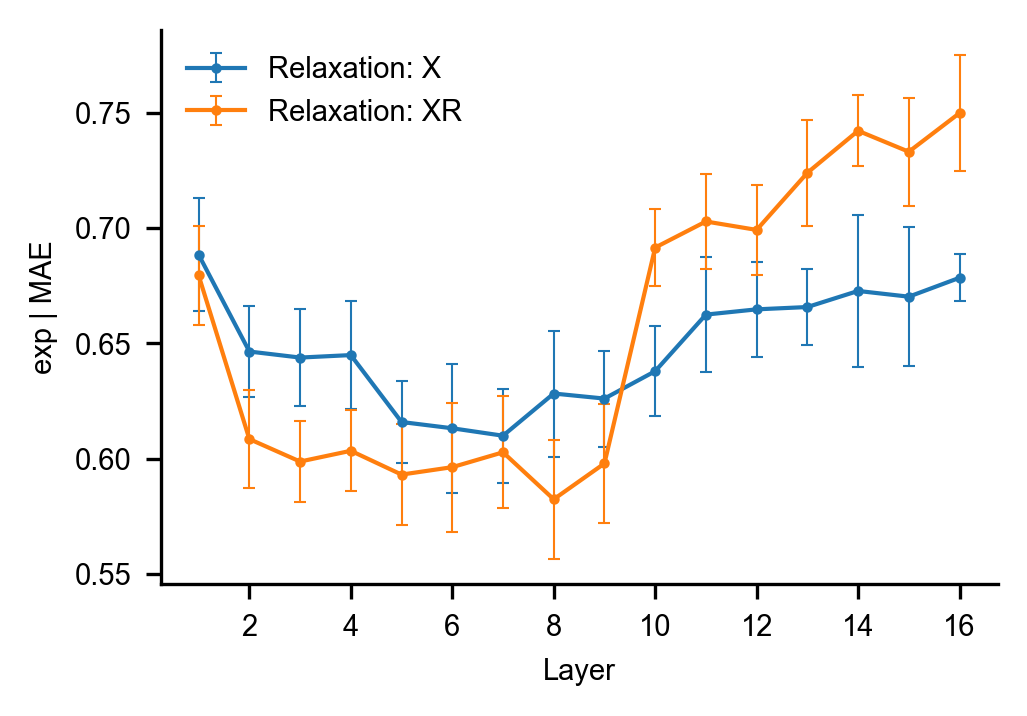

In [57]:
with open('/home/lucky/Projects/ion_conductivity/feat/output/output_Lipophilicity_dataset_relaxed.txt', 'r') as f:
    text_data = f.read()
visualize_metric_result(text_data, "exp", "MAE")
plt.savefig("figures/output_Lipophilicity_dataset_relaxed_exp_MAE.png", dpi=300)

/tmp/ipykernel_633432/574582036.py:41: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.figure(figsize=(3.6, 2.4))


0.6446264242432518

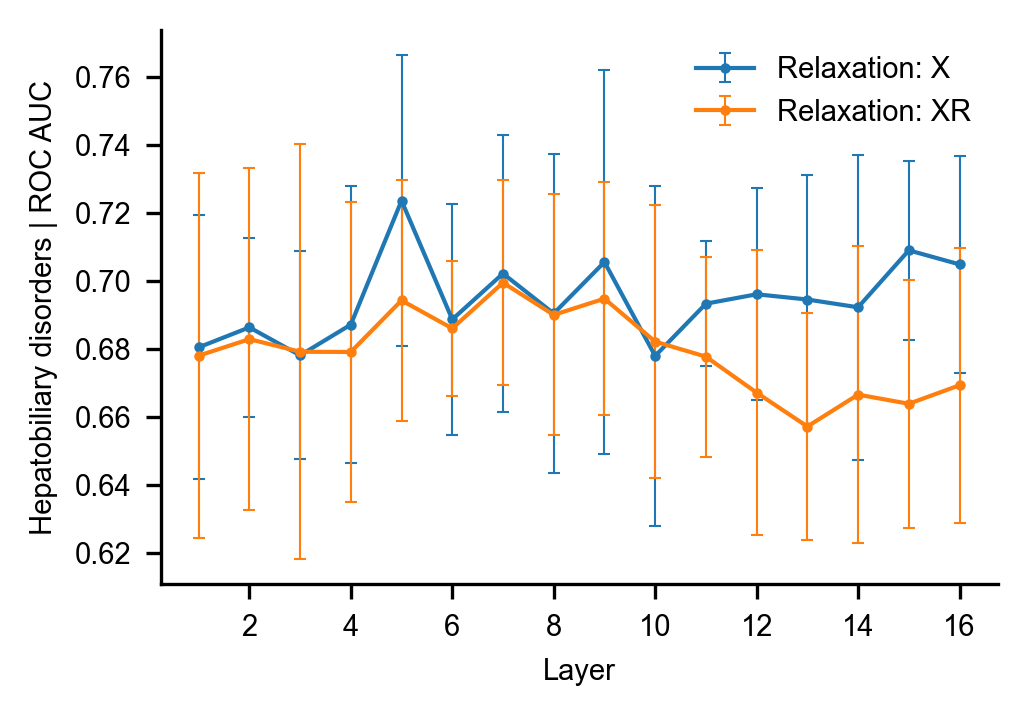

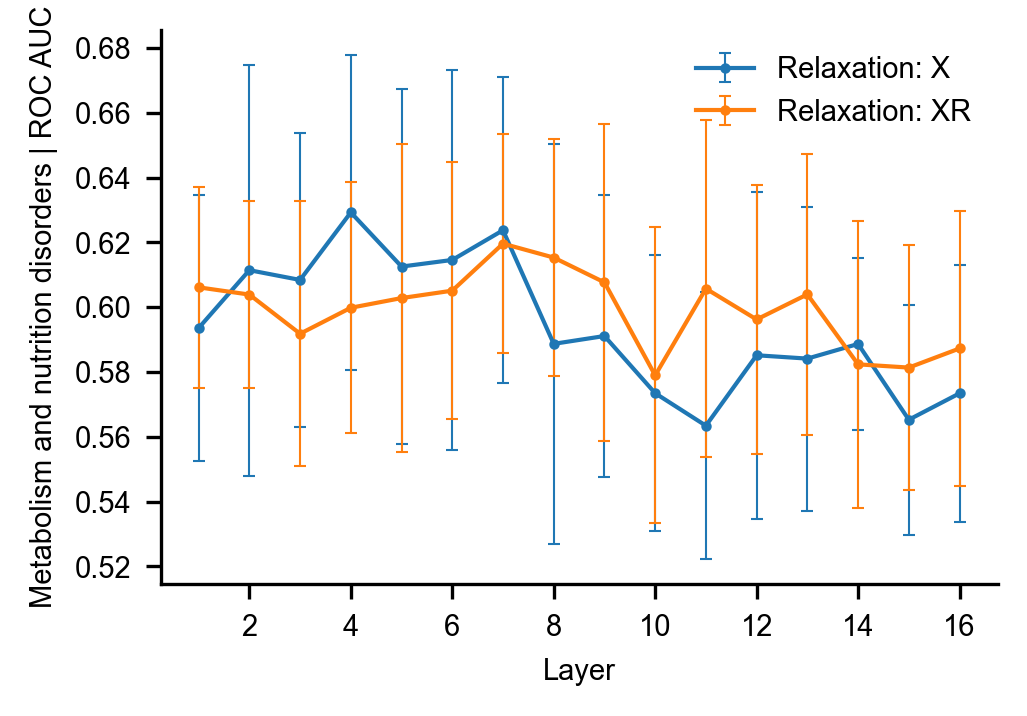

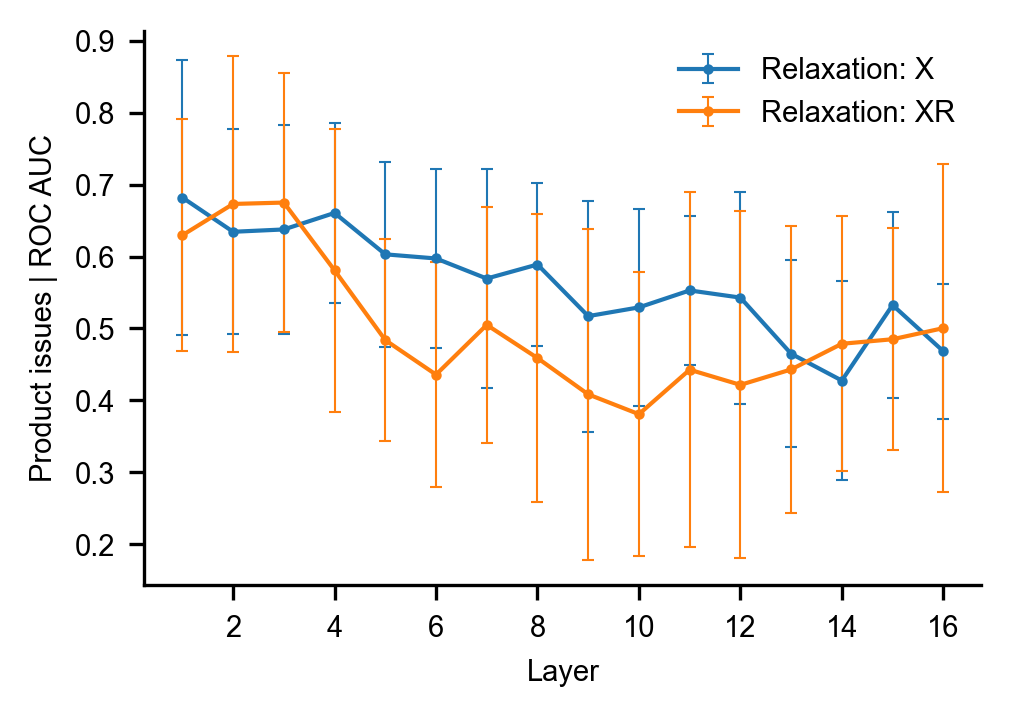

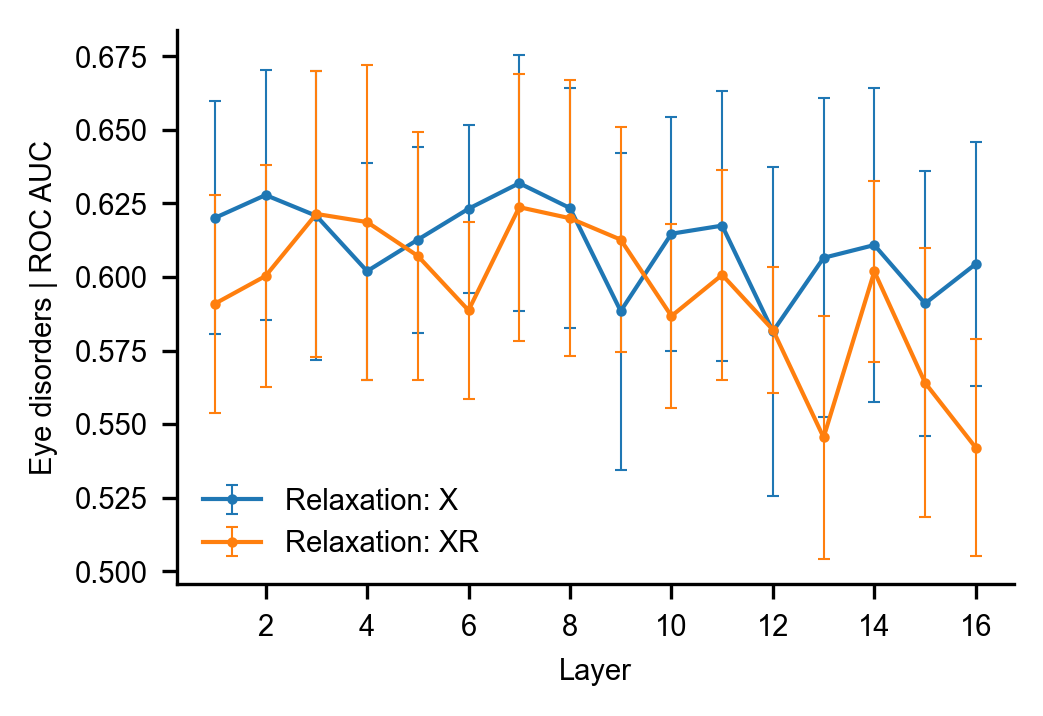

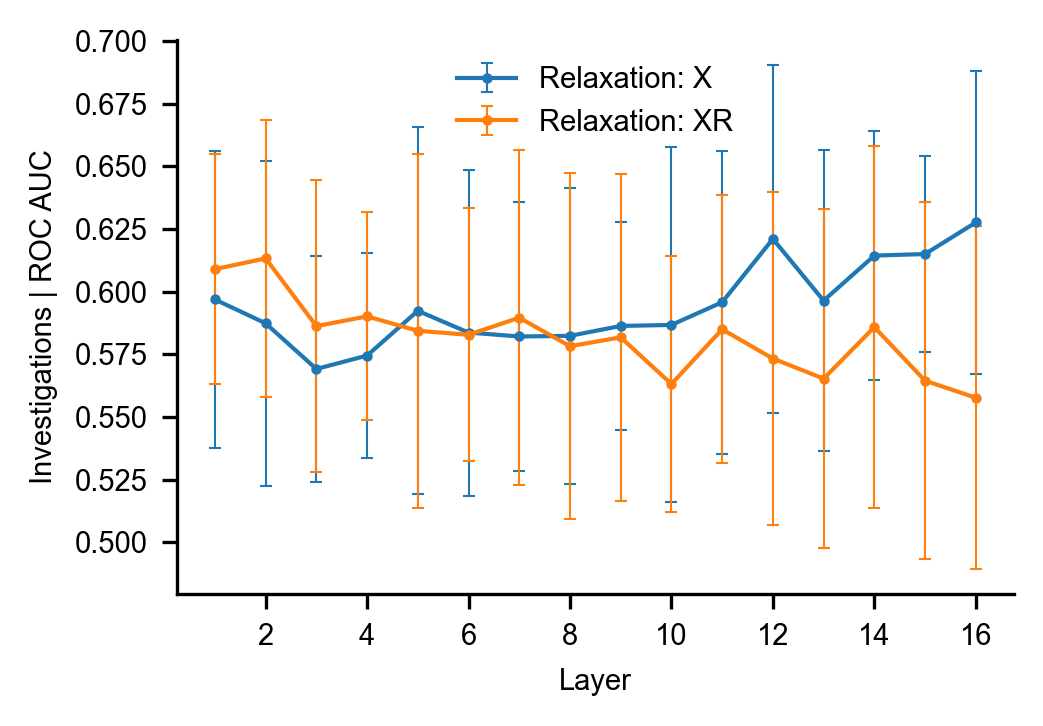

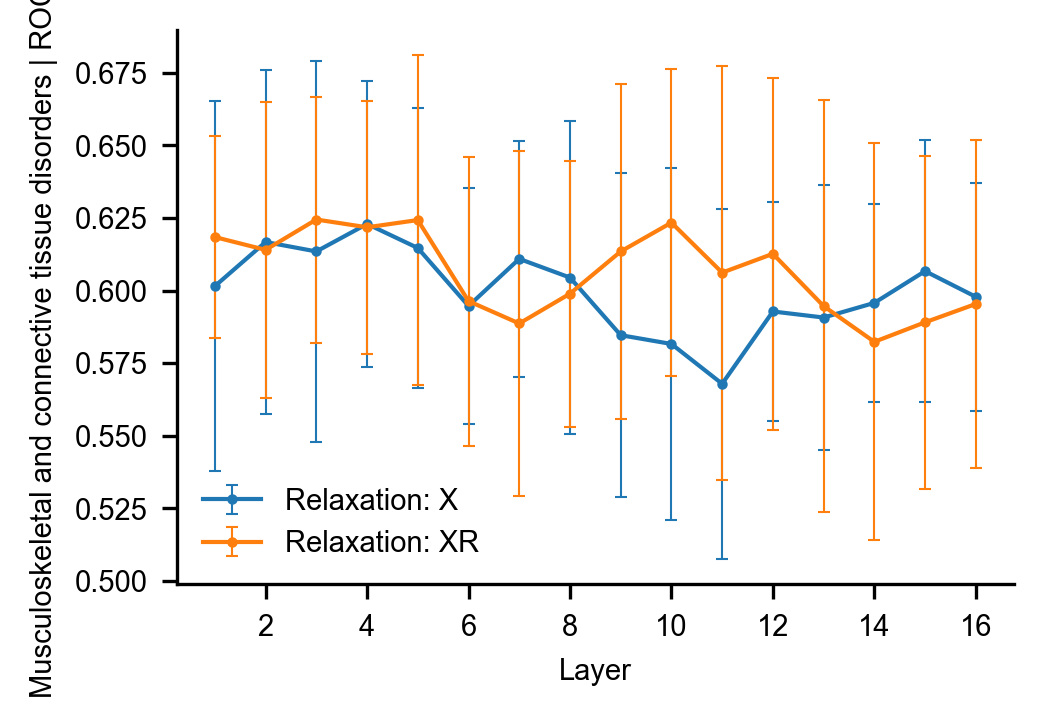

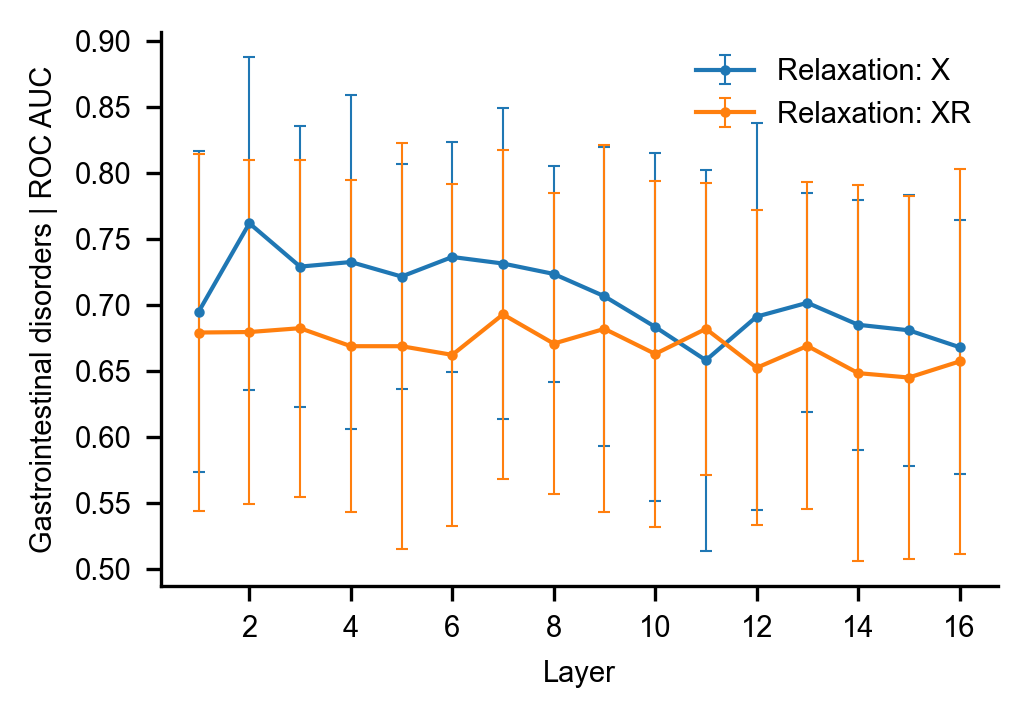

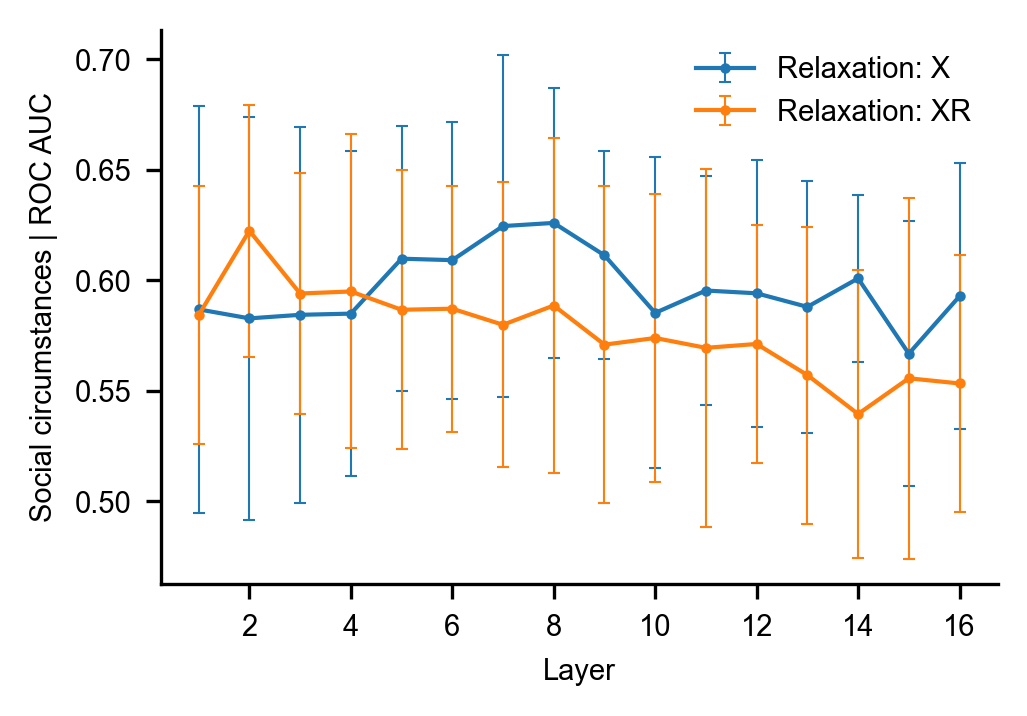

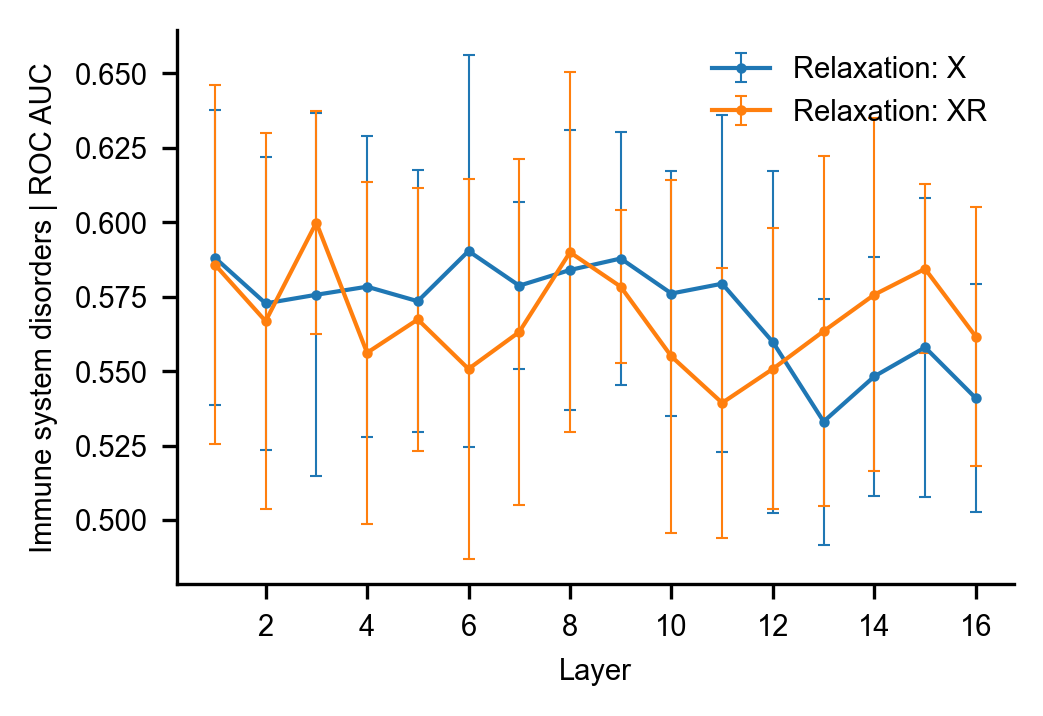

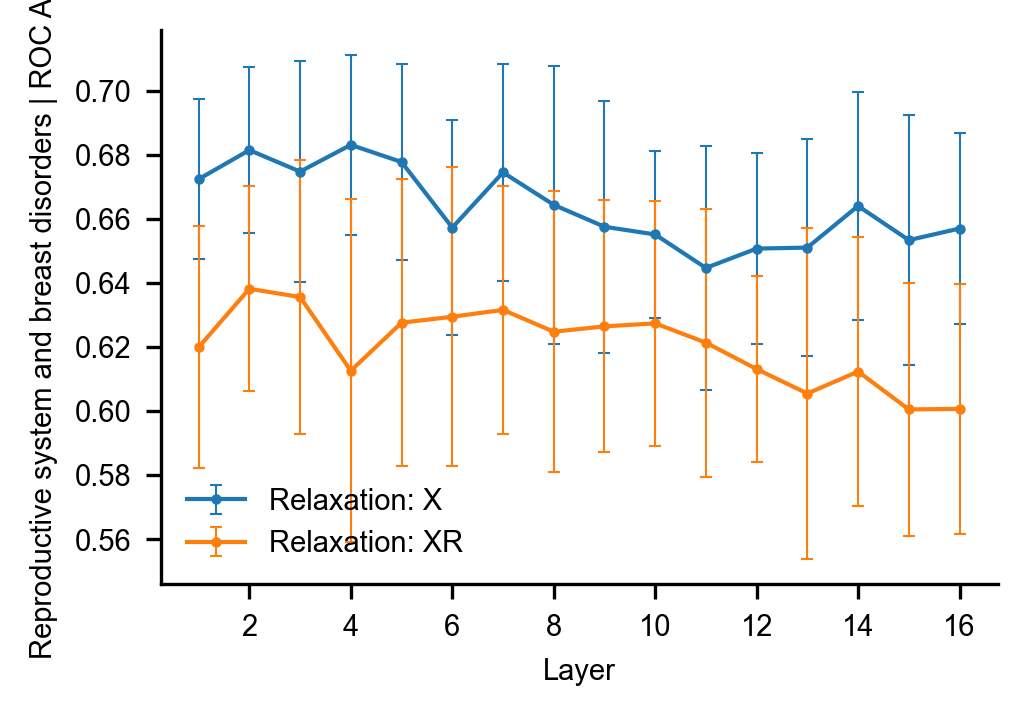

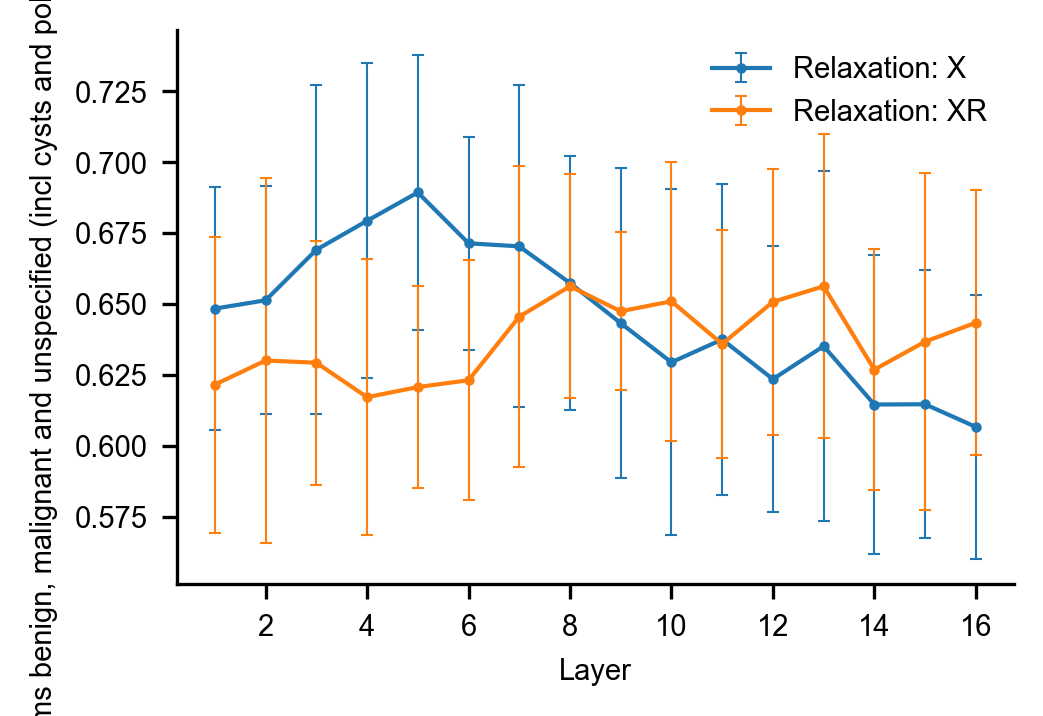

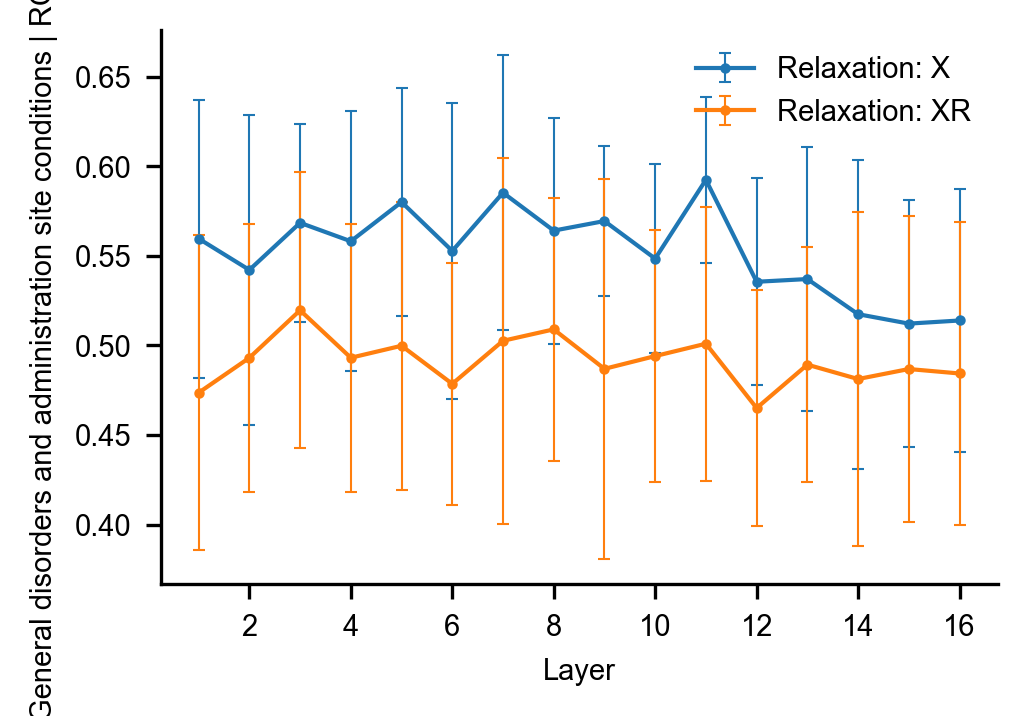

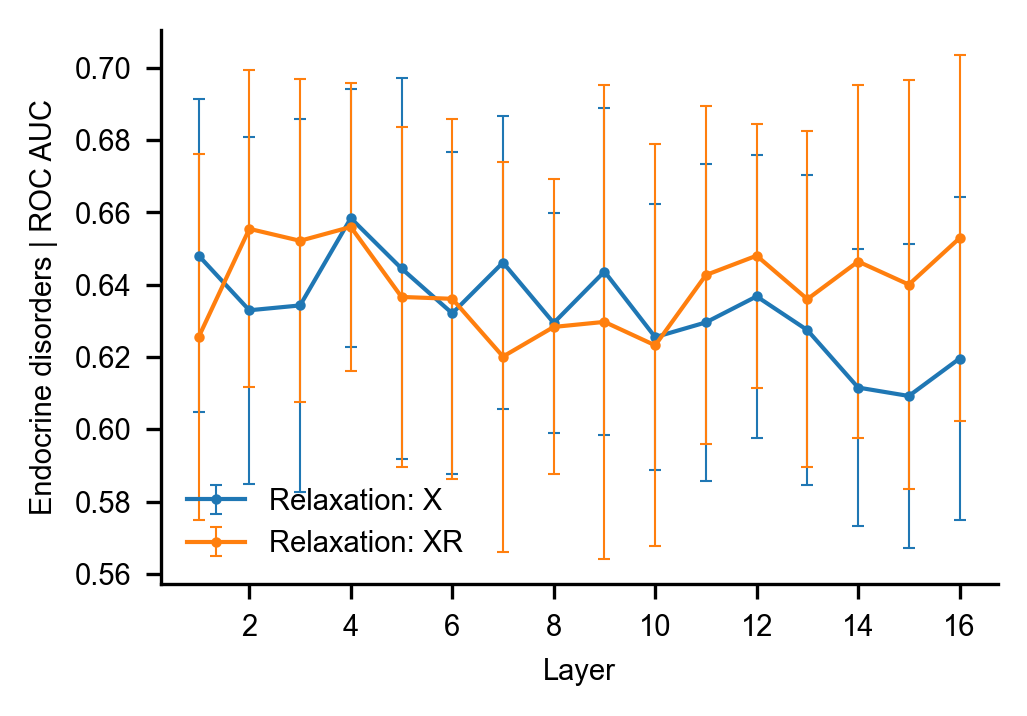

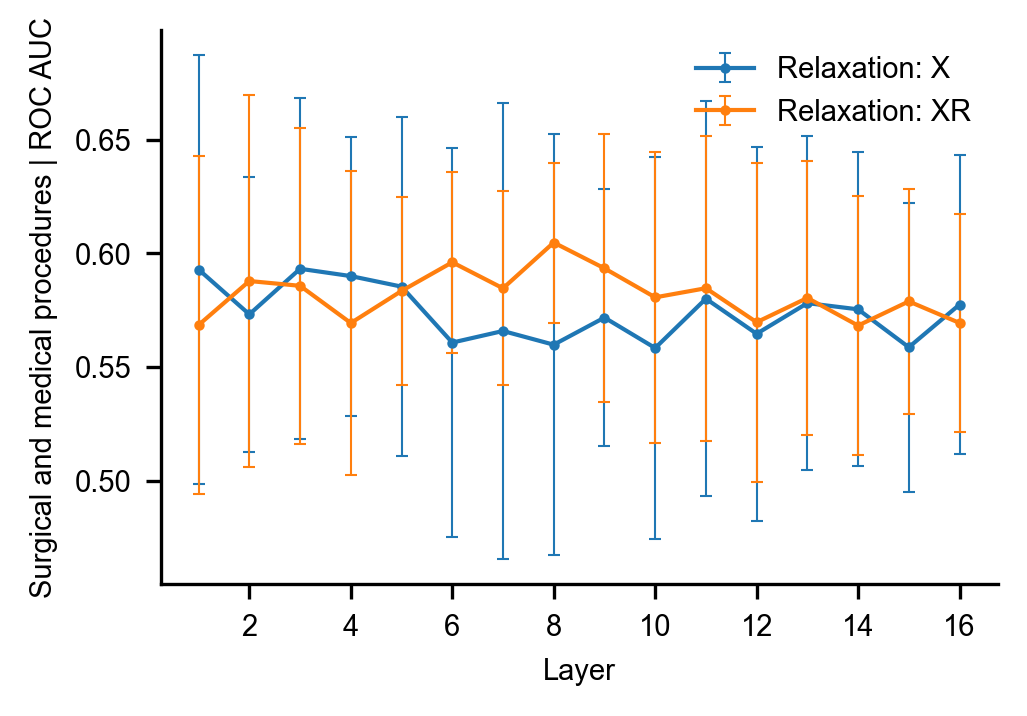

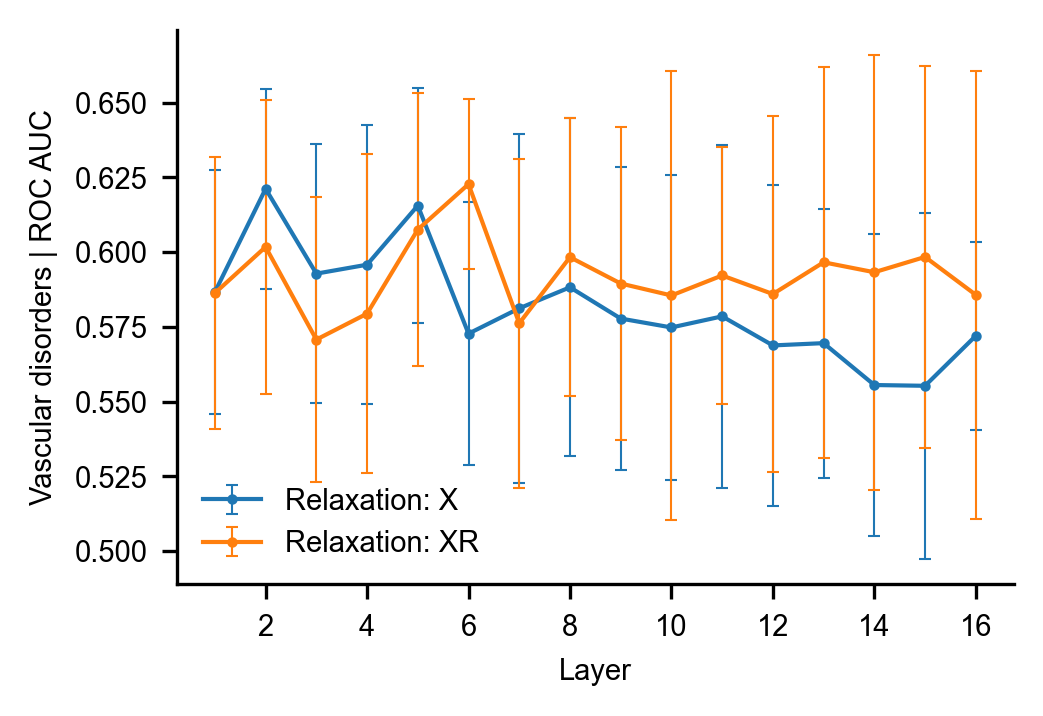

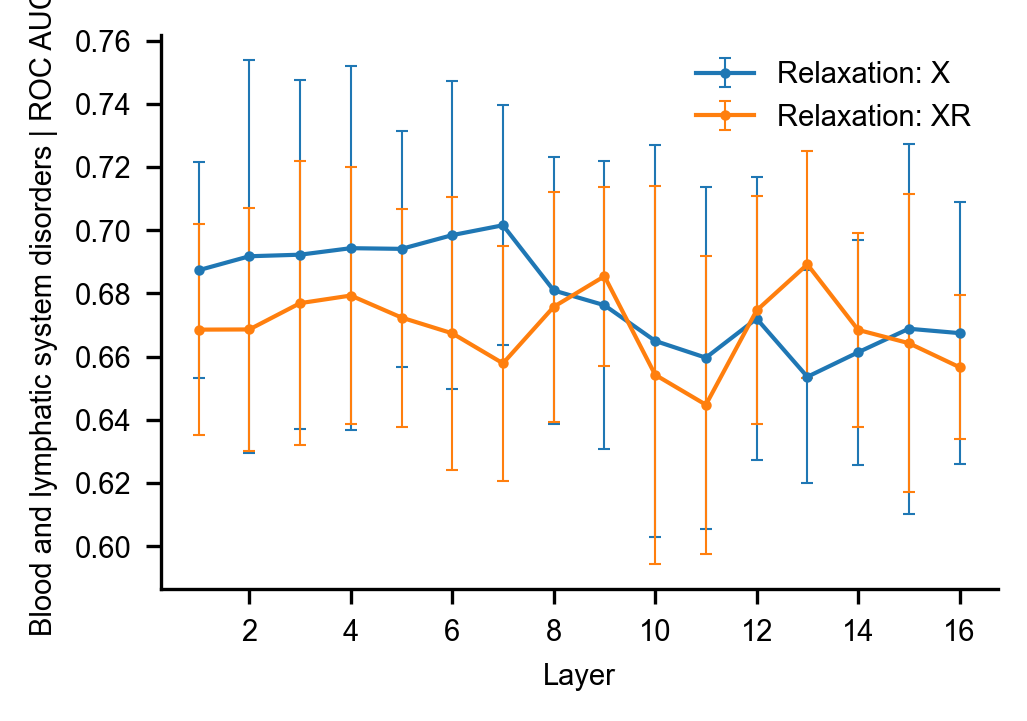

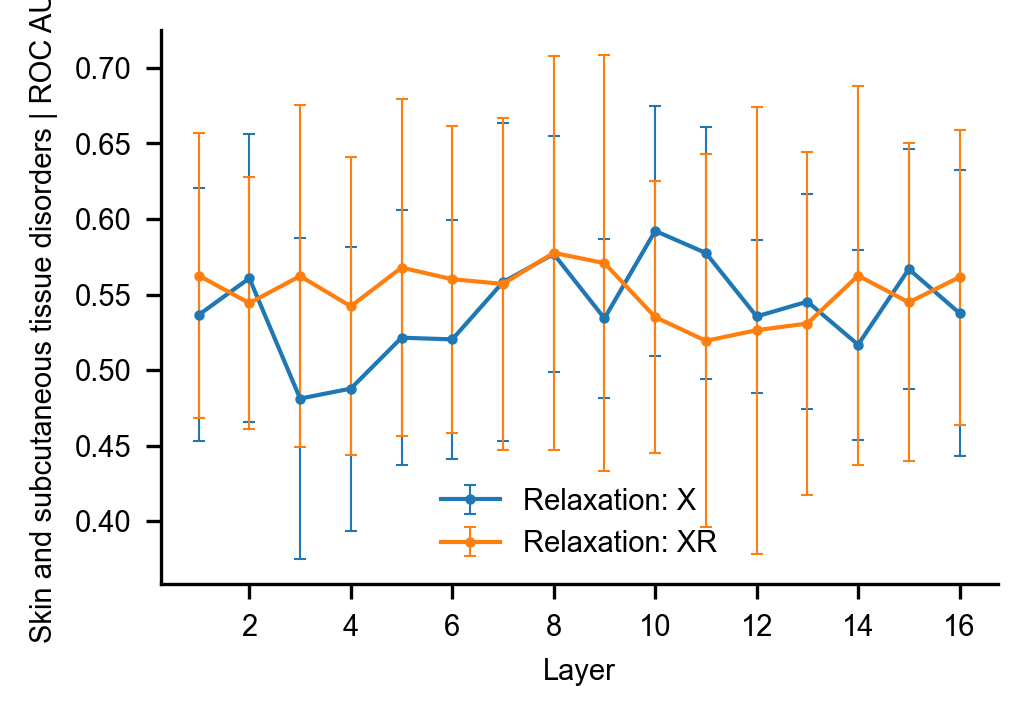

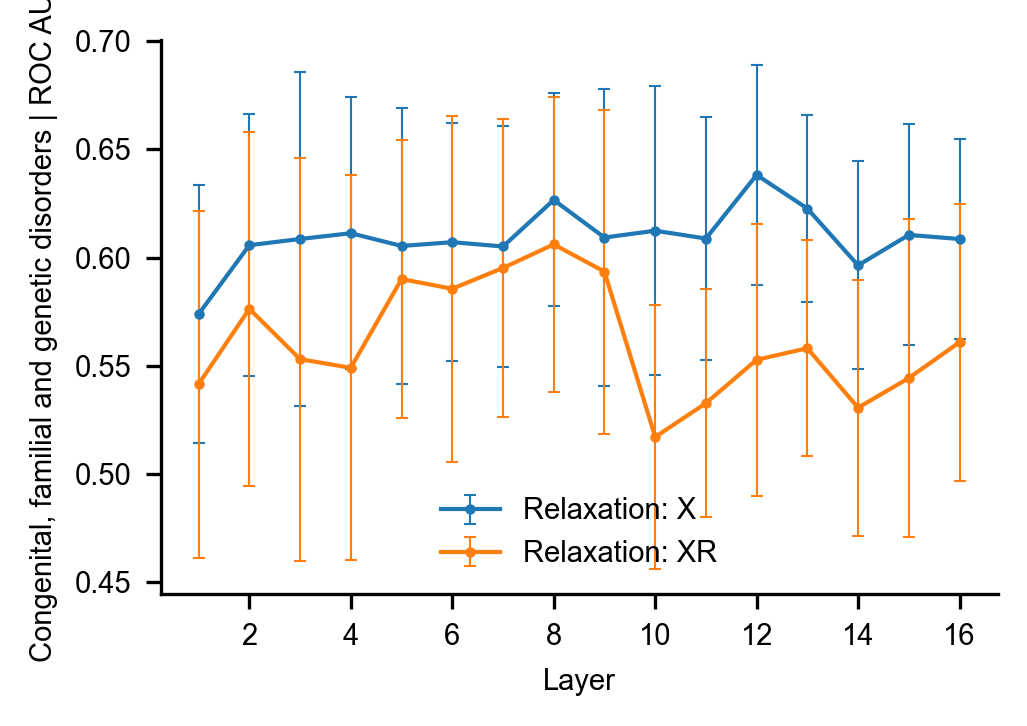

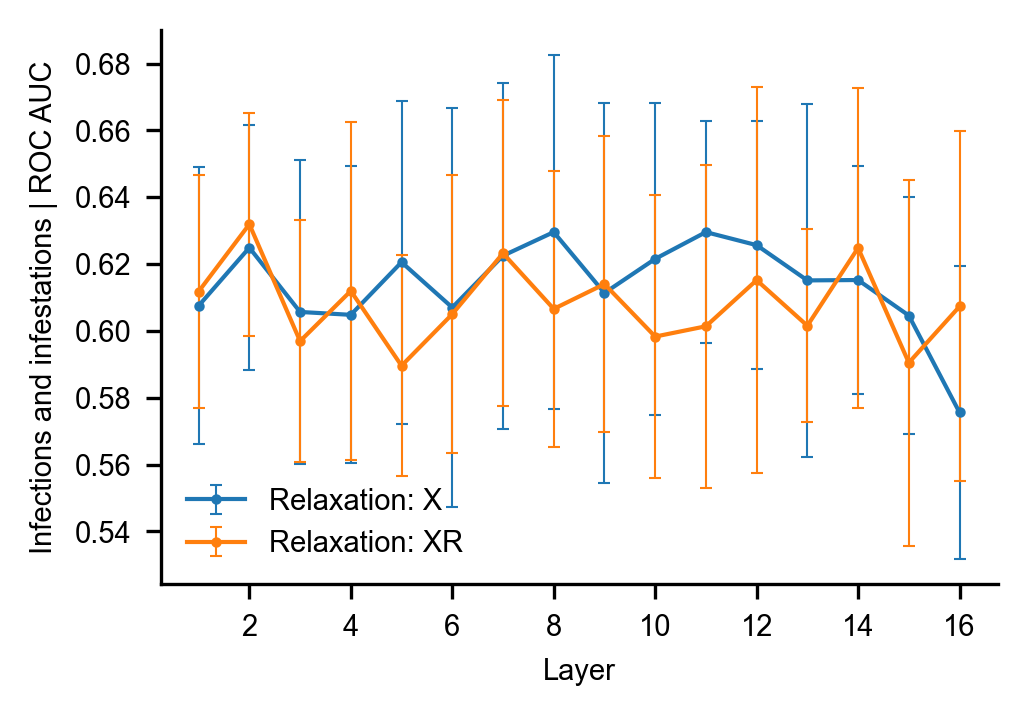

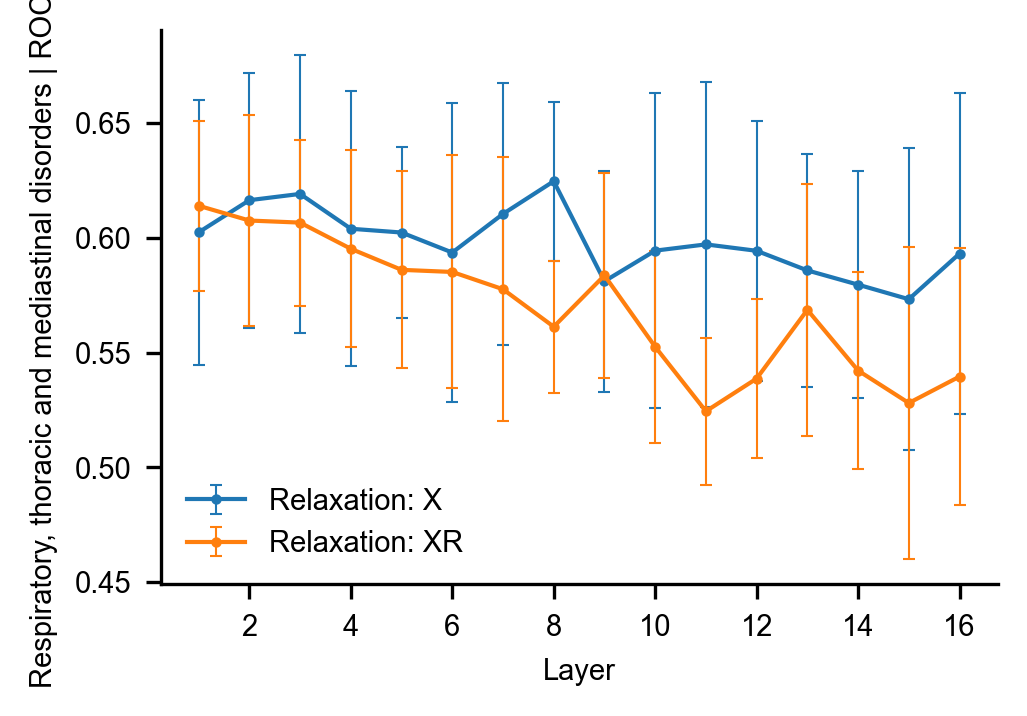

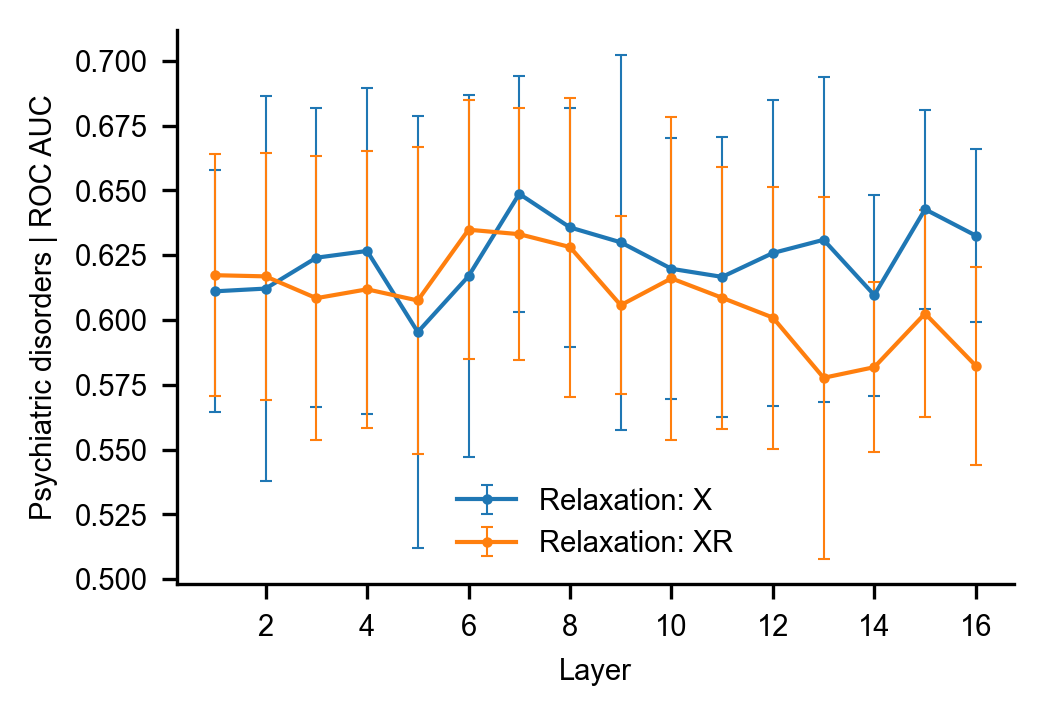

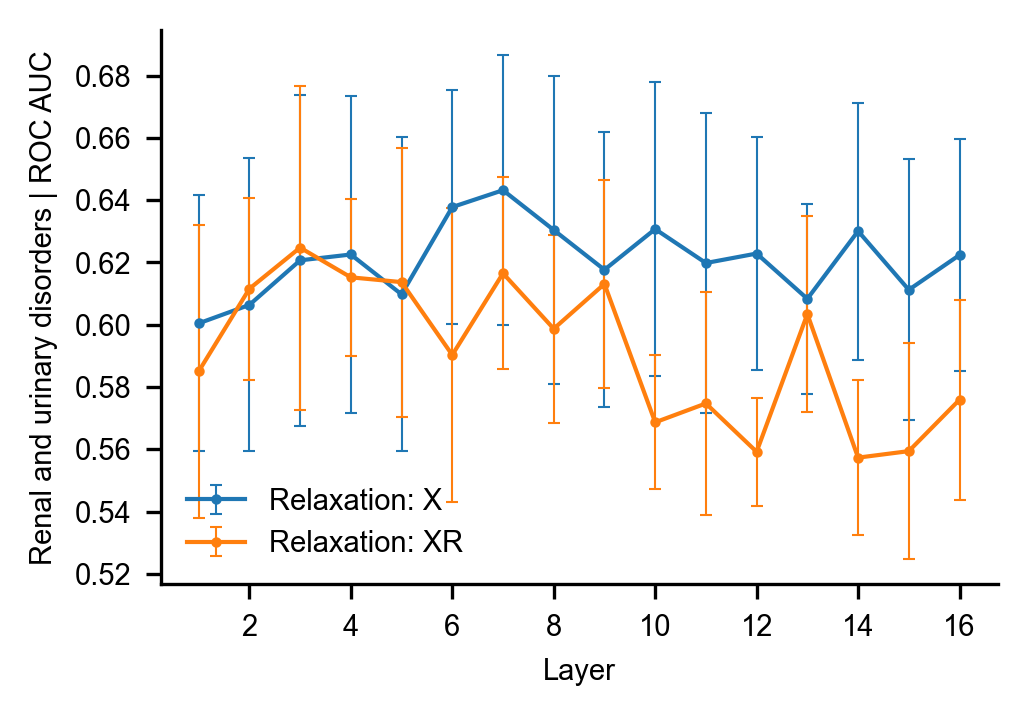

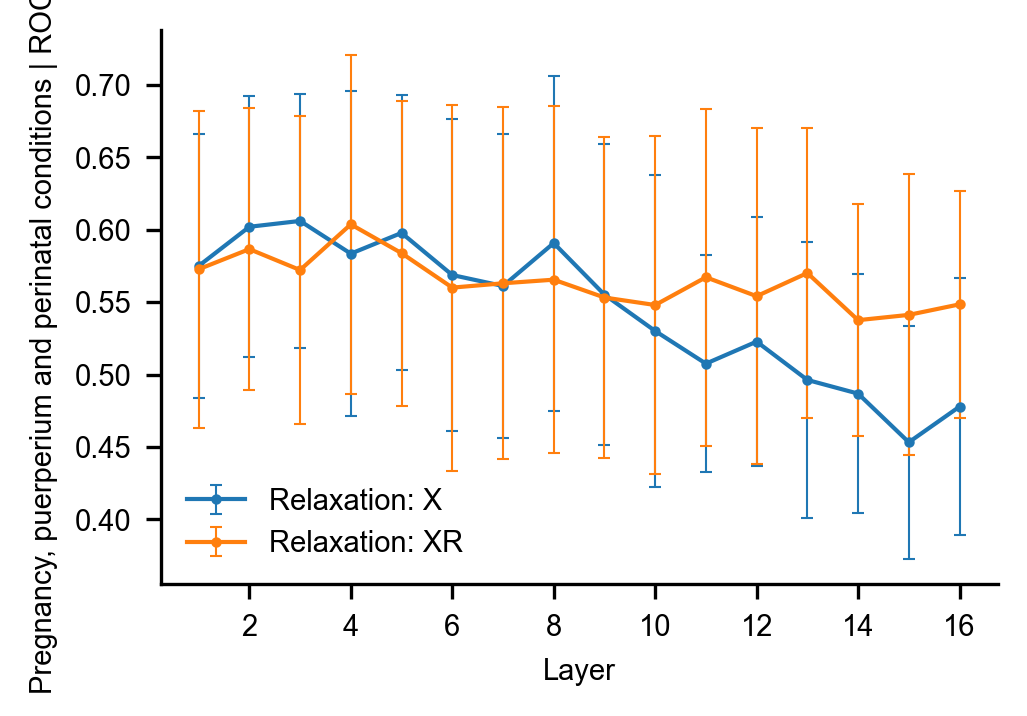

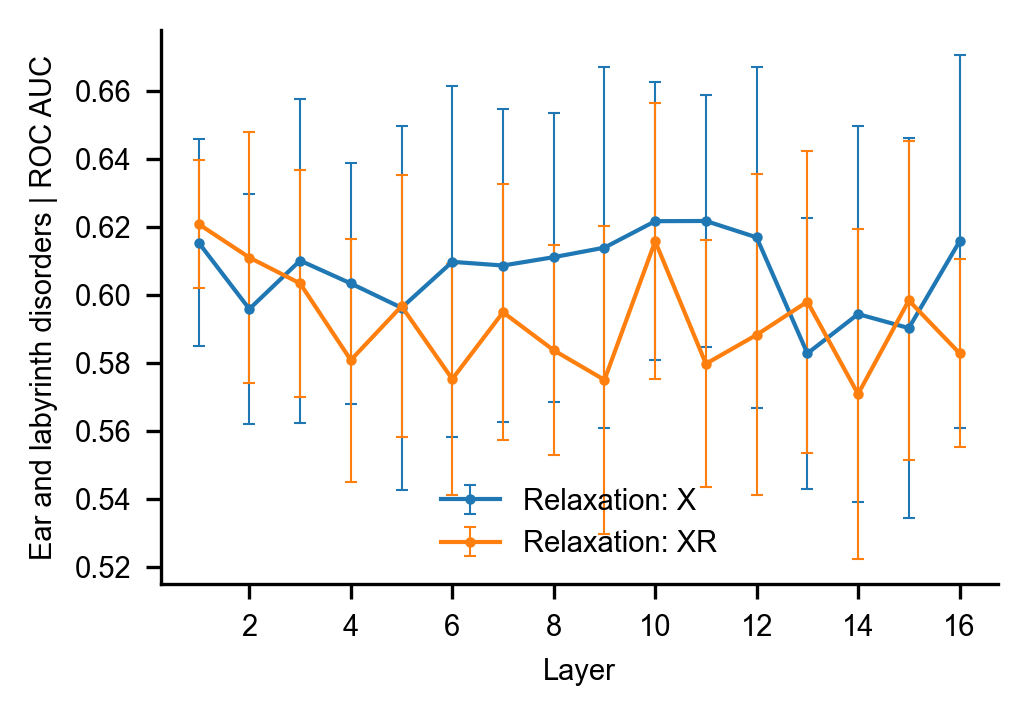

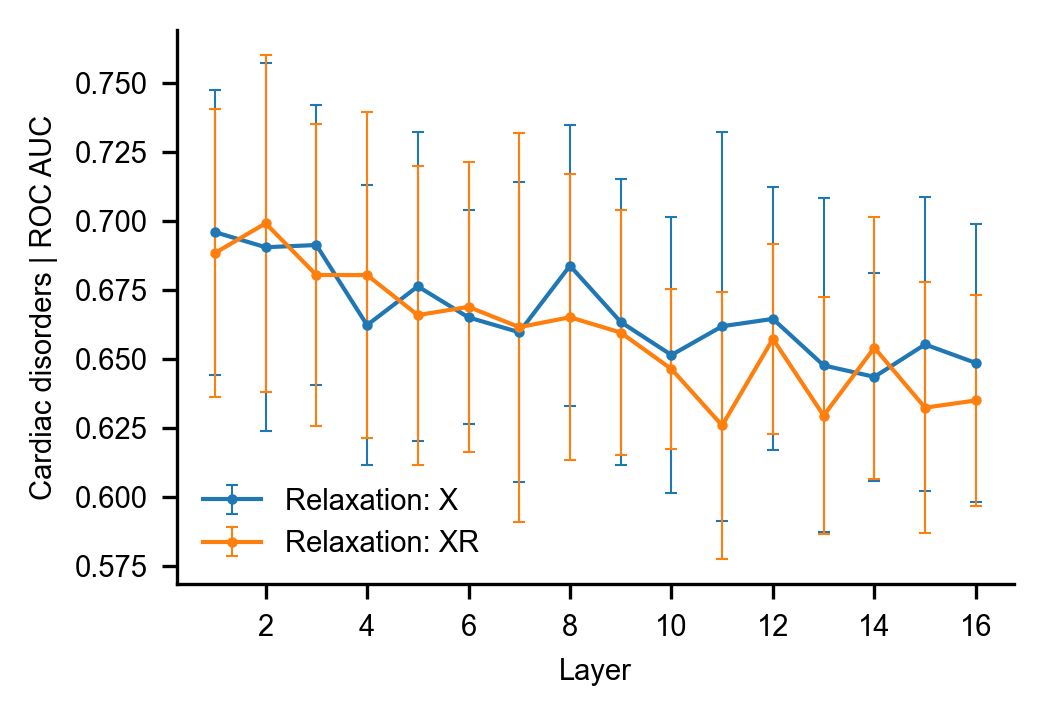

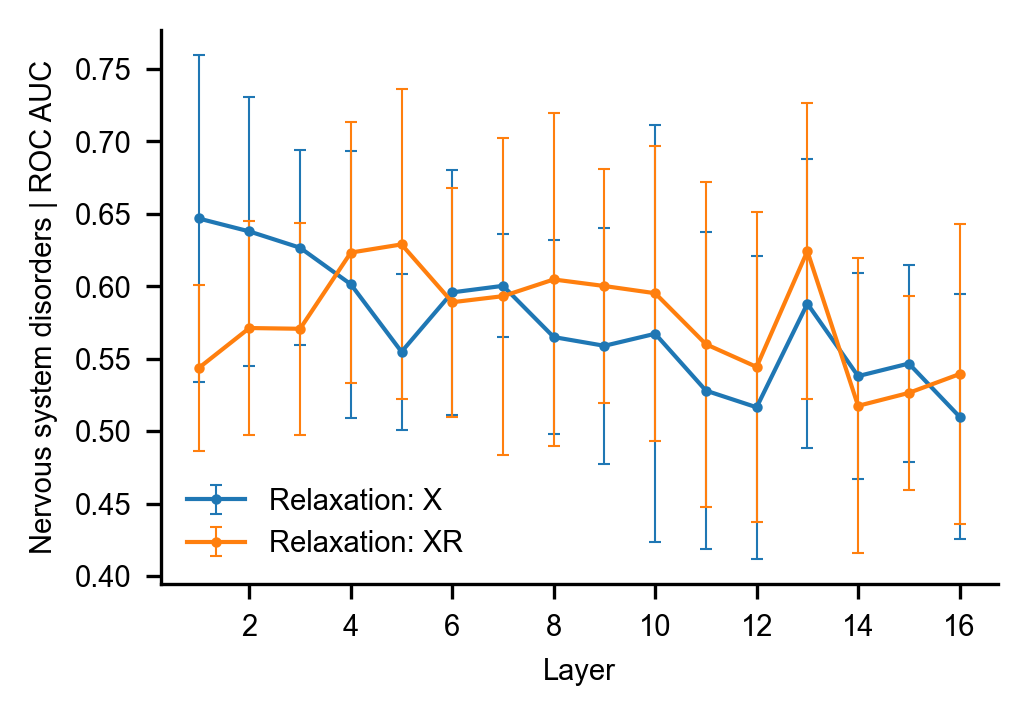

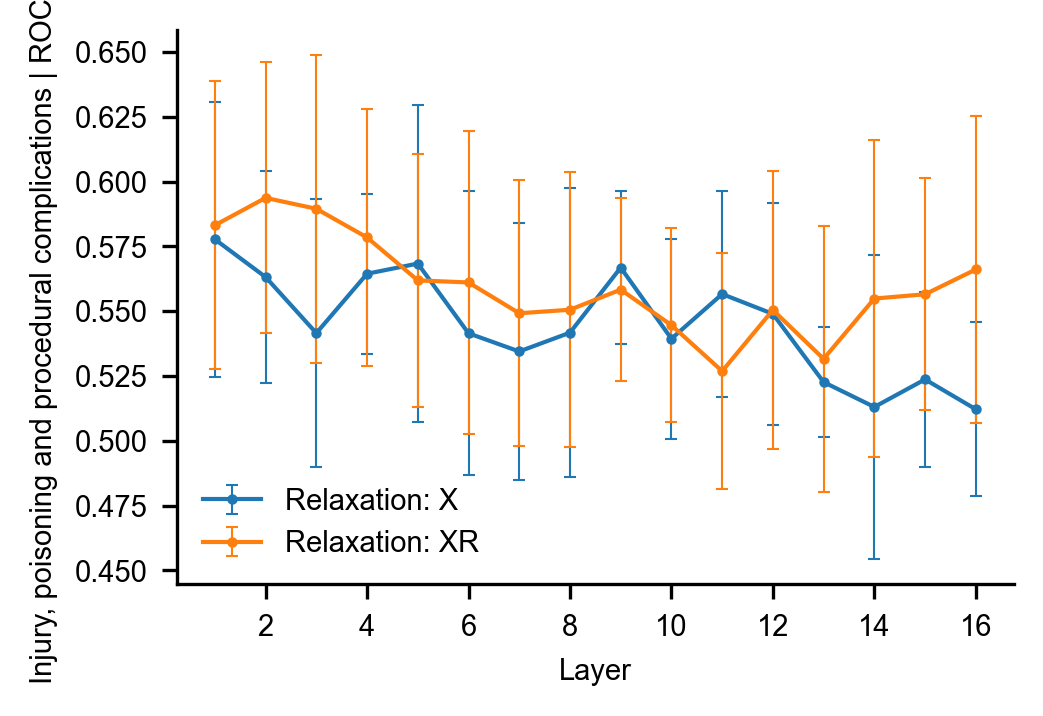

In [67]:
import pickle
with open('/home/lucky/Projects/ion_conductivity/feat/preprocessed_data/SIDER_dataset_relaxed.pkl', 'rb') as f:
    data = pickle.load(f)
with open('/home/lucky/Projects/ion_conductivity/feat/output/output_SIDER_dataset_relaxed.txt', 'r') as f:
    text_data = f.read()

max_metric = 0
for key in data['Y'].keys():
    df_corrected = visualize_metric_result(text_data, key, "ROC AUC")
    plt.savefig(f"figures/output_SIDER_dataset_relaxed_{key}_ROC_AUC.png", dpi=300)
    max_metric += df_corrected['METRIC'].max()
max_metric/len(data['Y'].keys())

51.3037049625266

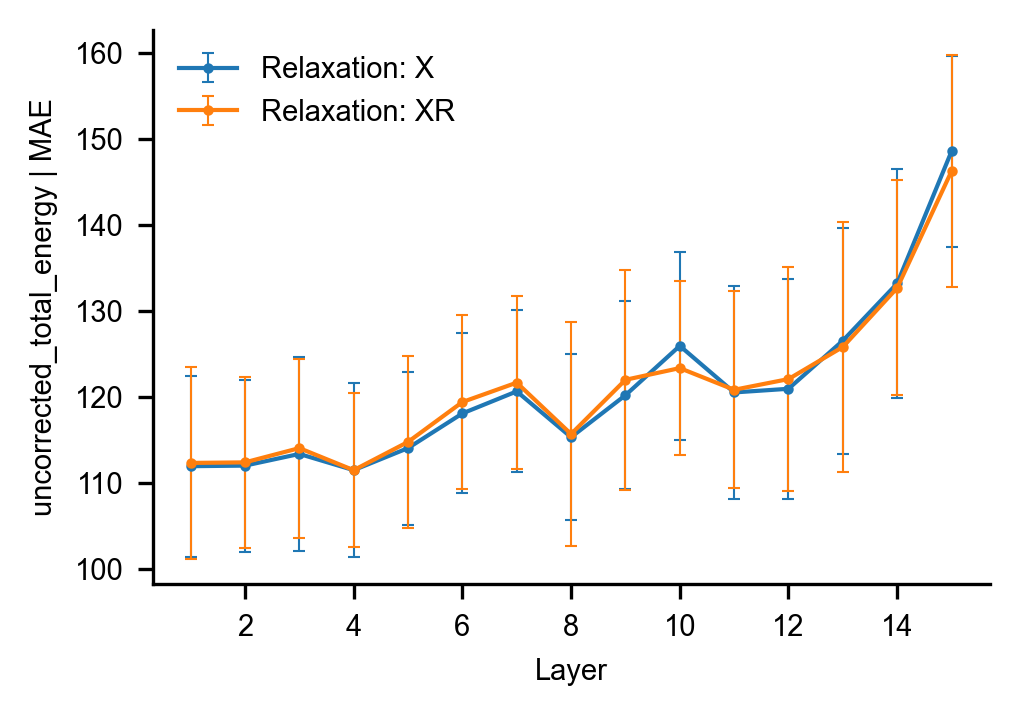

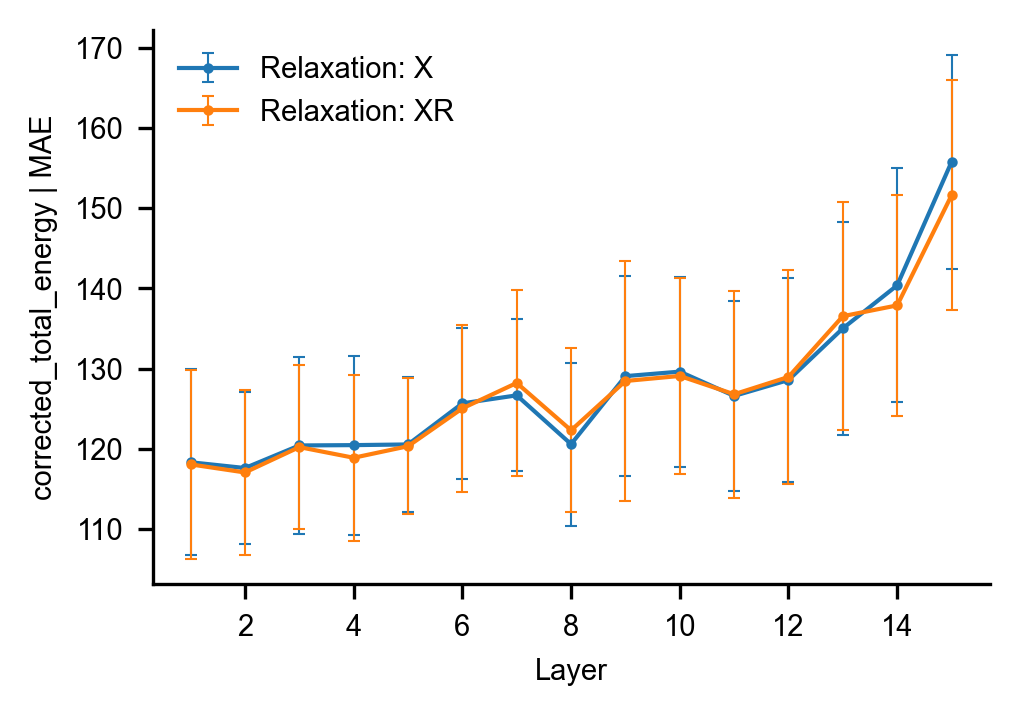

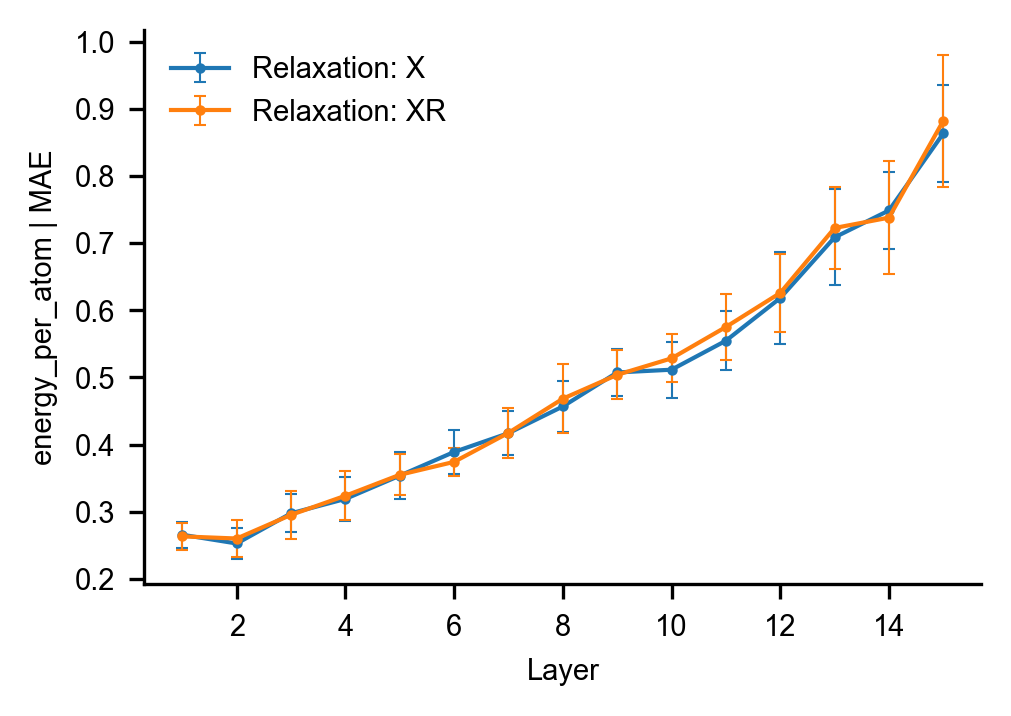

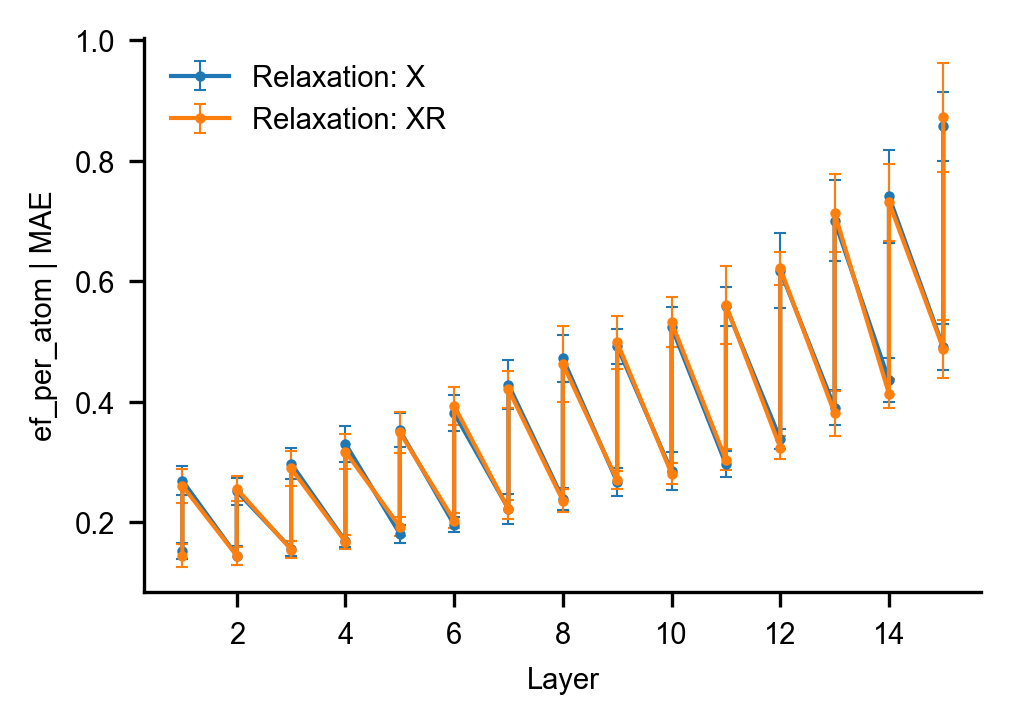

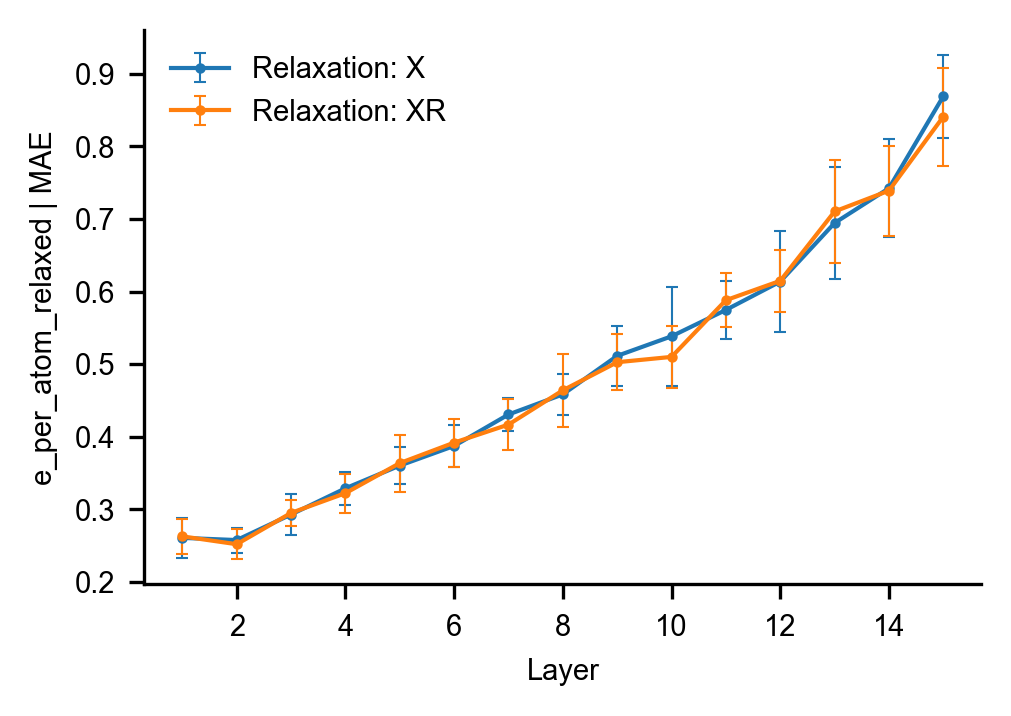

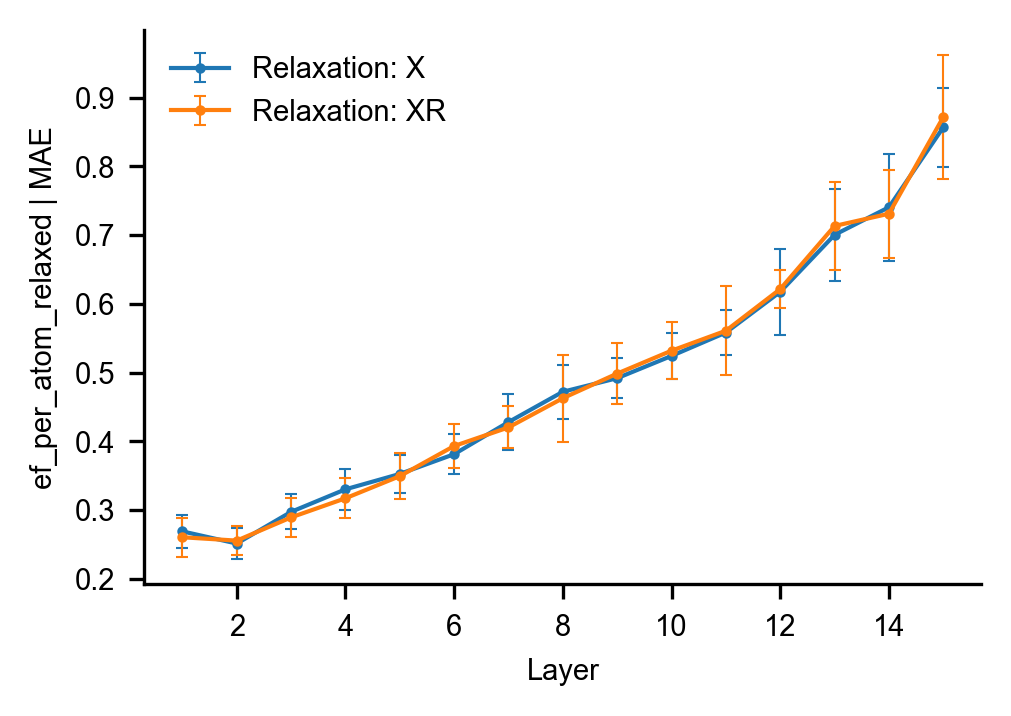

In [ ]:
import pickle
with open('/home/lucky/Projects/ion_conductivity/feat/preprocessed_data/MPtrj_2022_relaxed.pkl', 'rb') as f:
    data = pickle.load(f)
with open('/home/lucky/Projects/ion_conductivity/feat/output/output_MPtrj_2022_relaxed.txt', 'r') as f:
    text_data = f.read()

max_metric = 0
for key in data['Y'].keys():
    df_corrected = visualize_metric_result(text_data, key, "MAE")
    plt.savefig(f"figures/output_MPtrj_2022_relaxed_{key}_MAE.png", dpi=300)
    max_metric += df_corrected['METRIC'].max()
max_metric/len(data['Y'].keys())

In [47]:
import pandas as pd
import pickle
import json

In [56]:
df = pd.read_csv('data/bandgap_cif/MP.csv')
df

file                           element  \
0          0                            ['Ac']   
1          1                       ['Ac', 'O']   
2          2                      ['Ac', 'Br']   
3          3                 ['Ac', 'Br', 'O']   
4          4                      ['Ac', 'Cl']   
...      ...                               ...   
48965  48965        ['C', 'H', 'N', 'O', 'Zn']   
48966  48966             ['H', 'I', 'O', 'Zn']   
48967  48967             ['H', 'N', 'O', 'Zn']   
48968  48968  ['C', 'H', 'Hg', 'N', 'O', 'Zn']   
48969  48969      ['As', 'H', 'Hg', 'O', 'Zn']   

                            composition    Eg(eV)  
0                                 [1.0]  0.021639  
1                            [2.0, 3.0]  0.000000  
2                            [1.0, 3.0]  0.000000  
3                       [1.0, 1.0, 1.0]  0.000000  
4                            [1.0, 3.0]  0.000000  
...                                 ...       ...  
48965         [4.0, 9.0, 1.0, 6.0, 1.0]  0.123915  
48966              [1.0, 1.0, 4.0, 1.0]  0.041125  
48967              [1.0, 1.0, 4.0, 1.0]  0.134584  
48968  [4.0, 14.0, 2.0, 6.0, 13.0, 1.0]  0.314972  
48969         [1.0, 1.0, 1.0, 5.0, 1.0]  0.000000  

[48970 rows x 4 columns]

In [ ]:
#cif to ase
from ase.io import read
data_path = 'Exp'
i = 0
atoms = read(f'/home/lucky/Projects/ion_conductivity/feat/data/bandgap_cif/{data_path}_cif/{i}.cif')
atoms

Atoms(symbols='Te4Pd2Pb4Cl4O12', pbc=True, cell=[[5.554361, 0.0, 0.0], [0.0, 8.317594, 0.0], [0.0, 7.430361001720283, 11.036539000664398]], spacegroup_kinds=...)

In [11]:
from ase.io.jsonio import encode, decode

XR = []
for atoms_dict in data['XR']:
    atoms = decode(json.dumps(atoms_dict))
    XR.append(atoms)

XR[0]

Atoms(symbols='C2NC2NC2NC2N2H23', pbc=False)

In [2]:
# find files in '/home/lucky/Projects/llacha/data/data/'
import os
import glob

path = '/home/lucky/Projects/llacha/data/data/'
files = [f for f in glob.glob(path + "**/*.csv", recursive=True)]
files

['/home/lucky/Projects/llacha/data/data/ESOL_dataset.csv',
 '/home/lucky/Projects/llacha/data/data/QM8_dataset_iupac.csv',
 '/home/lucky/Projects/llacha/data/data/BACE_dataset.csv',
 '/home/lucky/Projects/llacha/data/data/BBBP_dataset.csv',
 '/home/lucky/Projects/llacha/data/data/QM9_dataset.csv',
 '/home/lucky/Projects/llacha/data/data/FreeSolv_dataset.csv',
 '/home/lucky/Projects/llacha/data/data/HIV_dataset.csv',
 '/home/lucky/Projects/llacha/data/data/QM7_dataset.csv',
 '/home/lucky/Projects/llacha/data/data/HIV_dataset_iupac.csv',
 '/home/lucky/Projects/llacha/data/data/SIDER_dataset.csv',
 '/home/lucky/Projects/llacha/data/data/QM9_dataset_xyz.csv',
 '/home/lucky/Projects/llacha/data/data/QM9_dataset_iupac.csv',
 '/home/lucky/Projects/llacha/data/data/ClinTox_dataset.csv',
 '/home/lucky/Projects/llacha/data/data/QM8_dataset.csv',
 '/home/lucky/Projects/llacha/data/data/QM7_dataset_iupac.csv',
 '/home/lucky/Projects/llacha/data/data/ToxCast_dataset.csv',
 '/home/lucky/Projects/lla

In [4]:
df = pd.read_csv('/home/lucky/Projects/llacha/data/data/SIDER_dataset.csv')
df

Unnamed: 0                                             smiles  \
0              0                                    C(CNCCNCCNCCN)N   
1              1  CC(C)(C)C1=CC(=C(C=C1NC(=O)C2=CNC3=CC=CC=C3C2=...   
2              2  CC[C@]12CC(=C)[C@H]3[C@H]([C@@H]1CC[C@]2(C#C)O...   
3              3    CCC12CC(=C)C3C(C1CC[C@]2(C#C)O)CCC4=CC(=O)CCC34   
4              4             C1C(C2=CC=CC=C2N(C3=CC=CC=C31)C(=O)N)O   
...          ...                                                ...   
1417        1417  C[C@H]1CN(CC[C@@]1(C)C2=CC(=CC=C2)O)C[C@H](CC3...   
1418        1418  CC[C@@H]1[C@@]2([C@@H]([C@@H](C(=O)[C@@H](C[C@...   
1419        1419  CCOC1=CC=C(C=C1)CC2=C(C=CC(=C2)[C@H]3[C@@H]([C...   
1420        1420  C1CN(CCC1N2C3=CC=CC=C3NC2=O)CCCC(C4=CC=C(C=C4)...   
1421        1421       CCC(=O)C(CC(C)N(C)C)(C1=CC=CC=C1)C2=CC=CC=C2   

      Hepatobiliary disorders  Metabolism and nutrition disorders  \
0                           1                                   1   
1                           0                                   1   
2                           0                                   1   
3                           1                                   1   
4                           1                                   1   
...                       ...                                 ...   
1417                        0                                   1   
1418                        1                                   1   
1419                        1                                   1   
1420                        0                                   1   
1421                        1                                   1   

      Product issues  Eye disorders  Investigations  \
0                  0              0               1   
1                  0              0               1   
2                  0              1               1   
3                  0              1               1   
4                  0              1               1   
...              ...            ...             ...   
1417               0              0               0   
1418               0              1               1   
1419               0              0               1   
1420               0              1               1   
1421               0              1               1   

      Musculoskeletal and connective tissue disorders  \
0                                                   1   
1                                                   1   
2                                                   0   
3                                                   1   
4                                                   1   
...                                               ...   
1417                                                1   
1418                                                1   
1419                                                1   
1420                                                1   
1421                                                1   

      Gastrointestinal disorders  Social circumstances  ...  \
0                              1                     0  ...   
1                              1                     0  ...   
2                              1                     0  ...   
3                              1                     0  ...   
4                              1                     0  ...   
...                          ...                   ...  ...   
1417                           1                     0  ...   
1418                           1                     0  ...   
1419                           1                     0  ...   
1420                           1                     0  ...   
1421                           1                     0  ...   

      Respiratory, thoracic and mediastinal disorders  Psychiatric disorders  \
0                                                   1                      1   
1                                                   1        

In [42]:
df['smiles'][5]

'CC[C@H](C)[C@H]1C(=O)N[C@H]2CSSC[C@@H](C(=O)N[C@@H](CSSC[C@@H](C(=O)NCC(=O)N[C@H](C(=O)N[C@H](C(=O)N[C@H](C(=O)N[C@H](C(=O)N[C@H](C(=O)N[C@H](C(=O)N[C@H](C(=O)N[C@H](C(=O)N[C@H](C(=O)N[C@H](C(=O)N[C@@H](CSSC[C@H](NC(=O)[C@@H](NC(=O)[C@@H](NC(=O)[C@@H](NC(=O)[C@@H](NC(=O)[C@@H](NC(=O)[C@@H](NC(=O)[C@@H](NC(=O)[C@@H](NC2=O)CO)CC(C)C)CC3=CC=C(C=C3)O)CCC(=O)N)CC(C)C)CCC(=O)O)CC(=O)N)CC4=CC=C(C=C4)O)C(=O)NCC(=O)O)C(=O)NCC(=O)N[C@@H](CCC(=O)O)C(=O)N[C@@H](CCCNC(=N)N)C(=O)NCC(=O)N[C@@H](CC5=CC=CC=C5)C(=O)N[C@@H](CC6=CC=CC=C6)C(=O)N[C@@H](CC7=CC=C(C=C7)O)C(=O)N[C@@H]([C@@H](C)O)C(=O)N8CCC[C@H]8C(=O)N[C@@H](CCCCN)C(=O)N[C@@H]([C@@H](C)O)C(=O)N[C@@H](CCCNC(=N)N)C(=O)N[C@@H](CCCNC(=N)N)C(=O)O)C(C)C)CC(C)C)CC9=CC=C(C=C9)O)CC(C)C)C)CCC(=O)O)C(C)C)CC(C)C)CC2=CN=CN2)CO)NC(=O)[C@H](CC(C)C)NC(=O)[C@H](CC2=CN=CN2)NC(=O)[C@H](CCC(=O)N)NC(=O)[C@H](CC(=O)N)NC(=O)[C@H](C(C)C)NC(=O)[C@H](CC2=CC=CC=C2)N)C(=O)N[C@H](C(=O)N[C@H](C(=O)N1)CO)[C@@H](C)O)NC(=O)[C@H](CCC(=O)N)NC(=O)[C@H](CCC(=O)O)NC(=O)[C@H](C(C)C)

In [ ]:
from feat.preprocessing_relaxation_moleculenet import smiles_to_ase
atoms = smiles_to_ase(df['smiles'][5], True)


ArgumentError: Python argument types in
    rdkit.Chem.rdDistGeom.EmbedMolecule(Mol, EmbedParameters)
did not match C++ signature:
    EmbedMolecule(RDKit::ROMol {lvalue} mol, RDKit::DGeomHelpers::EmbedParameters {lvalue} params)
    EmbedMolecule(RDKit::ROMol {lvalue} mol, unsigned int maxAttempts=0, int randomSeed=-1, bool clearConfs=True, bool useRandomCoords=False, double boxSizeMult=2.0, bool randNegEig=True, unsigned int numZeroFail=1, boost::python::dict {lvalue} coordMap={}, double forceTol=0.001, bool ignoreSmoothingFailures=False, bool enforceChirality=True, bool useExpTorsionAnglePrefs=True, bool useBasicKnowledge=True, bool printExpTorsionAngles=False, bool useSmallRingTorsions=False, bool useMacrocycleTorsions=True, unsigned int ETversion=2, bool useMacrocycle14config=True)

In [12]:
df['HIV_active'].value_counts()

HIV_active
0    39681
1     1443
Name: count, dtype: int64

In [12]:
["Hepatobiliary disorders", "Metabolism and nutrition disorders",
       "Product issues", "Eye disorders", "Investigations",
       "Musculoskeletal and connective tissue disorders",
       "Gastrointestinal disorders", "Social circumstances",
       "Immune system disorders", "Reproductive system and breast disorders",
       "Neoplasms benign, malignant and unspecified (incl cysts and polyps)",
       "General disorders and administration site conditions",
       "Endocrine disorders", "Surgical and medical procedures",
       "Vascular disorders", "Blood and lymphatic system disorders",
       "Skin and subcutaneous tissue disorders",
       "Congenital, familial and genetic disorders",
       "Infections and infestations",
       "Respiratory, thoracic and mediastinal disorders",
       "Psychiatric disorders", "Renal and urinary disorders",
       "Pregnancy, puerperium and perinatal conditions",
       "Ear and labyrinth disorders", "Cardiac disorders",
       "Nervous system disorders",
       "Injury, poisoning and procedural complications"]

['NR-AR',
 'NR-AR-LBD',
 'NR-AhR',
 'NR-Aromatase',
 'NR-ER',
 'NR-ER-LBD',
 'NR-PPAR-gamma',
 'SR-ARE',
 'SR-ATAD5',
 'SR-HSE',
 'SR-MMP',
 'SR-p53']

In [20]:
df.keys()[2:-2]

Index(['Hepatobiliary disorders', 'Metabolism and nutrition disorders',
       'Product issues', 'Eye disorders', 'Investigations',
       'Musculoskeletal and connective tissue disorders',
       'Gastrointestinal disorders', 'Social circumstances',
       'Immune system disorders', 'Reproductive system and breast disorders',
       'Neoplasms benign, malignant and unspecified (incl cysts and polyps)',
       'General disorders and administration site conditions',
       'Endocrine disorders', 'Surgical and medical procedures',
       'Vascular disorders', 'Blood and lymphatic system disorders',
       'Skin and subcutaneous tissue disorders',
       'Congenital, familial and genetic disorders',
       'Infections and infestations',
       'Respiratory, thoracic and mediastinal disorders',
       'Psychiatric disorders', 'Renal and urinary disorders',
       'Pregnancy, puerperium and perinatal conditions',
       'Ear and labyrinth disorders', 'Cardiac disorders',
       'Nervous sys

In [13]:
for key in df.keys():
    print(key)

Unnamed: 0
smiles
Hepatobiliary disorders
Metabolism and nutrition disorders
Product issues
Eye disorders
Investigations
Musculoskeletal and connective tissue disorders
Gastrointestinal disorders
Social circumstances
Immune system disorders
Reproductive system and breast disorders
Neoplasms benign, malignant and unspecified (incl cysts and polyps)
General disorders and administration site conditions
Endocrine disorders
Surgical and medical procedures
Vascular disorders
Blood and lymphatic system disorders
Skin and subcutaneous tissue disorders
Congenital, familial and genetic disorders
Infections and infestations
Respiratory, thoracic and mediastinal disorders
Psychiatric disorders
Renal and urinary disorders
Pregnancy, puerperium and perinatal conditions
Ear and labyrinth disorders
Cardiac disorders
Nervous system disorders
Injury, poisoning and procedural complications
Descriptions
count


In [ ]:


X = df['smiles']
Y = df[''

In [6]:
with open('/home/lucky/Projects/ion_conductivity/feat/preprocessed_data/SIDER_dataset_relaxed.pkl', 'rb')    as f:
    data = pickle.load(f)

data.keys()

dict_keys(['X', 'XR', 'SMILES', 'Y'])

In [27]:
data['Y']['Hepatobiliary disorders']

[1.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0]

In [12]:
from ase.io.jsonio import encode, decode

XR = []
for atoms_dict in data['XR']:
    atoms = decode(json.dumps(atoms_dict))
    XR.append(atoms)

XR[0]

Atoms(symbols='C2NC2NC2NC2N2H23', pbc=False)

In [21]:
# ase visualize
from ase.visualize import view

view(XR[7], viewer='x3d')

IndexError: list index out of range

In [28]:
# file generated time for the files in directory
import os
import time
path = '/home/lucky/Projects/ion_conductivity/feat/preprocessed_data/'
# calculate time using os
files = os.listdir(path)

for file in files:
    # in human readable format
    print(file, time.ctime(os.path.getmtime(path + file)))

files


ClinTox_dataset_relaxed.pkl Mon Feb  3 21:00:23 2025
BBBP_dataset_relaxed.pkl Mon Feb  3 21:00:34 2025
ESOL_dataset_relaxed.pkl Mon Feb  3 21:53:44 2025
BACE_dataset_relaxed.pkl Mon Feb  3 21:00:39 2025
FreeSolv_dataset_relaxed.pkl Mon Feb  3 21:40:33 2025
HIV_dataset_relaxed.pkl Mon Feb  3 21:01:06 2025
Lipophilicity_dataset_relaxed.pkl Mon Feb  3 21:01:08 2025
SIDER_dataset_relaxed.pkl Mon Feb  3 21:28:41 2025
Tox21_dataset_relaxed.pkl Mon Feb  3 21:00:59 2025


['ClinTox_dataset_relaxed.pkl',
 'BBBP_dataset_relaxed.pkl',
 'ESOL_dataset_relaxed.pkl',
 'BACE_dataset_relaxed.pkl',
 'FreeSolv_dataset_relaxed.pkl',
 'HIV_dataset_relaxed.pkl',
 'Lipophilicity_dataset_relaxed.pkl',
 'SIDER_dataset_relaxed.pkl',
 'Tox21_dataset_relaxed.pkl']

In [4]:
x_list = [1, 2, 3, 4, 5]
for x in x_list[:4]:
    print(x)

1
2
3
4


In [8]:
data['XR'][0]

{'numbers': {'__ndarray__': [[36],
   'int64',
   [6,
    6,
    7,
    6,
    6,
    7,
    6,
    6,
    7,
    6,
    6,
    7,
    7,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1]]},
 'positions': {'__ndarray__': [[36, 3],
   'float64',
   [4.742466007113968,
    0.9510064593648784,
    0.452100260913958,
    4.567920551010624,
    -0.5768825812862615,
    0.46776497960367935,
    3.334701971824055,
    -0.9645626860800346,
    1.1396470796778648,
    2.144499371527051,
    -0.9338224274812202,
    0.3012054745203223,
    0.8570828567893056,
    -1.1743894969536675,
    1.1116007039460054,
    -0.36515519826344617,
    -1.2125639073079715,
    0.31020455662419844,
    -0.7879388182551165,
    0.08287022757869399,
    -0.23473634516088235,
    -2.187237229911386,
    0.0048656072845271485,
    -0.8348154672475099,
    -3.1651282263480187,
    -0.47818367067749307,
    0

In [8]:
" ".join(["measured log solubility in mols per litre"]) 

'measured log solubility in mols per litre'

In [5]:
import deepchem as dc

# BACE 데이터셋 로드
tasks, datasets, transformers = dc.molnet.load_bace_classification(featurizer='raw', )

# 훈련, 검증, 테스트 데이터셋 분할
train_dataset, valid_dataset, test_dataset = datasets

# 데이터셋 크기 출력
print(f"Training dataset size: {len(train_dataset)}")
print(f"Validation dataset size: {len(valid_dataset)}")
print(f"Test dataset size: {len(test_dataset)}")

# 데이터셋 샘플 확인
X, y, w = train_dataset.X, train_dataset.y, train_dataset.w
print(f"Feature shape: {X.shape}, Labels shape: {y.shape}")


Training dataset size: 1210
Validation dataset size: 151
Test dataset size: 152
Feature shape: (1210,), Labels shape: (1210, 1)


In [6]:
datasets

(<DiskDataset X.shape: (1210,), y.shape: (1210, 1), w.shape: (1210, 1), task_names: ['Class']>,
 <DiskDataset X.shape: (151,), y.shape: (151, 1), w.shape: (151, 1), ids: ['S1(=O)(=O)CC(Cc2cc(F)c3NCC4(CCC4)c3c2)C(O)C([NH2+]Cc2cc(ccc2)C(C)(C)C)C1'
  'Fc1cc(cc(F)c1)CC(NC(=O)C)C(O)C[NH2+]C1(CCCCC1)c1cc(ccc1)C1CCOCOC1'
  'Clc1ccc(nc1)C(=O)Nc1cc(ccc1)C1(N=C(N)c2c1cccc2)C' ...
  'S(=O)(=O)(N(c1cc(cc(c1)/C(=N\\OCc1ccccc1)/C)C(=O)N[C@H]([C@@H](O)C[NH2+]Cc1cc(OC)ccc1)Cc1cc(F)cc(F)c1)c1ccccc1)C'
  'S1(=O)(=O)CC(Cc2cc(OC3CCC3)c(N)c(F)c2)C(O)C([NH2+]Cc2cc(ccc2)C(C)(C)C)C1'
  'O(C)c1cc(ccc1)C[NH2+]CC(O)C(NC(=O)C(N1CCC(NC(=O)C)(CC2CC2)C1=O)CCc1ccccc1)Cc1ccccc1'], task_names: ['Class']>,
 <DiskDataset X.shape: (152,), y.shape: (152, 1), w.shape: (152, 1), ids: ['O1CCC(CC1)CNC(=O)C(Cc1cc2cc(ccc2nc1N)-c1ccccc1C)C'
  'O1c2ncc(cc2C([NH2+]CC(O)C2NC(=O)C=3C=CC(=O)N(CCCCc4cc(C2)ccc4)C=3)CC12CCC2)CC(C)(C)C'
  'O1c2ncc(cc2C([NH2+]CC(O)C(NC(=O)COC)Cc2cc(ccc2)-c2occn2)CC12CCC2)CC(C)(C)C'
  ...
  'Fc1c2c(ccc1)[C@

In [23]:
import deepchem as dc

# 데이터셋 다운로드
tasks, datasets, transformers = dc.molnet.load_pdbbind(featurizer='raw', subset='general')

# 데이터셋 분리
train_dataset, valid_dataset, test_dataset = datasets

# 데이터 개수 출력
print(f"Train set size: {len(train_dataset)}")
print(f"Validation set size: {len(valid_dataset)}")
print(f"Test set size: {len(test_dataset)}")


Train set size: 154
Validation set size: 19
Test set size: 20


In [28]:
DATASETS_URL = "https://deepchemdata.s3-us-west-1.amazonaws.com/datasets/"
PDBBIND_URL = DATASETS_URL + "pdbbindv2019/"
PDBBIND_TASKS = ['-logKd/Ki']
filename = 'pdbbind_v2019_refined.tar.gz'
dc.utils.data_utils.download_url(url=PDBBIND_URL + filename,
                                                 dest_dir='./')

In [26]:
print(train_dataset.X[0])  # 첫 번째 샘플의 피처
print(train_dataset.y[0])  # 첫 번째 샘플의 라벨 (바인딩 친화도)


['/tmp/v2013-core/2obf/2obf_ligand.sdf'
 '/tmp/v2013-core/2obf/2obf_pocket.pdb']
1.1064013674972386


# JSD

In [3]:
import torch
class JSD(torch.nn.Module):
    def __init__(self):
        super(JSD, self).__init__()
        self.kl = torch.nn.KLDivLoss(reduction='batchmean', log_target=True)

    def forward(self, p: torch.tensor, q: torch.tensor):
        p, q = p.view(-1, p.size(-1)).log_softmax(-1), q.view(-1, q.size(-1)).log_softmax(-1)
        m = (0.5 * (p + q))
        return 0.5 * (self.kl(m, p) + self.kl(m, q))

import torch
import torch.nn.functional as F

def jsd_torch(p, q, eps=1e-8):
    """
    두 확률 분포 p, q 간의 Jensen-Shannon Divergence (JSD) 계산 (PyTorch 버전)
    
    :param p: torch.Tensor, shape=(N, D) -> 확률 분포 (softmax 적용됨)
    :param q: torch.Tensor, shape=(N, D) -> 확률 분포 (softmax 적용됨)
    :param eps: 작은 값 (log 안정성 확보용)
    :return: torch.Tensor, shape=(N,) -> 각 샘플별 JSD 값
    """
    # 확률 분포 정규화 (Softmax)
    p = F.softmax(p, dim=-1)
    q = F.softmax(q, dim=-1)

    # 평균 분포 M
    m = 0.5 * (p + q)

    # KL Divergence 계산
    kl_p_m = torch.sum(p * (torch.log(p + eps) - torch.log(m + eps)), dim=-1)
    kl_q_m = torch.sum(q * (torch.log(q + eps) - torch.log(m + eps)), dim=-1)

    # 최종 JSD 계산
    jsd = 0.5 * (kl_p_m + kl_q_m)

    return torch.sqrt(jsd)


In [4]:
# To ensure jsd same
from scipy.spatial.distance import jensenshannon
# import softmax
from scipy.special import softmax
print(jensenshannon(softmax([9, 0.1]), softmax([0.9, 0.1])))
print(jsd_torch(torch.tensor([9, 0.1]), torch.tensor([0.9, 0.1])))

0.34811866844619355
tensor(0.3481)


In [5]:
from orb_models.forcefield import atomic_system, pretrained

device = 'cpu'
orbff = pretrained.orb_v2(device=device)
orbff.model.eval()

def get_graph_features_by_layer(atoms, model, device):
    """
    Get the graph features from the model until the specified layer.
    
    Args:
    - atoms (dict): Dictionary containing the atomic coordinates and atomic numbers.
    - model (OrbFrozenMLP): The model to extract the features from.
    - layer_until (int): The layer until which the features are extracted. (1-15)
    - device (str): The device to run the model on.
    
    Returns:
    - np.ndarray: The graph features.
    """
    graph = atomic_system.ase_atoms_to_atom_graphs(atoms, device=device)
    graph = model.featurize_edges(graph)
    graph = model.featurize_nodes(graph)
    graph = model._encoder(graph)

    feats = []
    for gnn in model.gnn_stacks:
        graph = gnn(graph)
        feats.append(graph.node_features['feat'].cpu())

    
    jsd = [jsd_torch(feat, feats[-1]).numpy() for feat in feats]
    return feats, jsd

/home/lucky/anaconda3/envs/ionic/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/home/lucky/anaconda3/envs/ionic/lib/python3.10/site-packages/orb_models/forcefield/pretrained.py:71: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch

In [4]:
from ase.io import read

atoms = read('/home/lucky/Projects/ion_conductivity/feat/KLi6TaO6_mp-9059_primitive.cif')

In [15]:
import pickle
from ase.io.jsonio import encode, decode
import json


with open('/home/lucky/Projects/ion_conductivity/feat/preprocessed_data/BBBP_dataset_relaxed.pkl', 'rb') as f:
    data = pickle.load(f)

atoms = decode(json.dumps(data['XR'][0]))

In [2]:

from rdkit import Chem
from rdkit.Chem import AllChem
from ase import Atoms
from ase.io.jsonio import encode, decode
from ase.optimize import BFGS
def smiles_to_ase(smiles, conformation=False):
    """
    Convert a SMILES string into a 3D ASE Atoms object using RDKit.
    """
    # Convert SMILES to RDKit molecule
    mol = Chem.MolFromSmiles(smiles)
    if mol is None:
        raise ValueError(f"Could not parse SMILES string: {smiles}")
    
    # Add hydrogen atoms
    mol = Chem.AddHs(mol)
    
    if conformation:
        # Generate a 3D conformation using ETKDG_v3
        AllChem.EmbedMolecule(mol, maxAttempts=10)
        AllChem.UFFOptimizeMolecule(mol, maxIters=100)
    else:
        # Generate a 2D conformation
        AllChem.Compute2DCoords(mol)
    
    # Extract atomic positions from the RDKit conformer
    conformer = mol.GetConformer()
    positions = []
    symbols = []
    for atom in mol.GetAtoms():
        pos = conformer.GetAtomPosition(atom.GetIdx())
        positions.append((pos.x, pos.y, pos.z))
        symbols.append(atom.GetSymbol())
    
    # Create an ASE Atoms object
    ase_atoms = Atoms(symbols=symbols, positions=positions)
    return ase_atoms


In [2]:
atoms = smiles_to_ase('CN1C=NC2=C1C(=O)N(C(=O)N2C)C')

In [2]:
data['SMILES'][0]

'[Cl].CC(C)NCC(O)COc1cccc2ccccc12'

In [7]:
data['SMILES'][11]   

'CC1=CN([C@H]2C[C@H](F)[C@@H](CO)O2)C(=O)NC1=O'

In [ ]:
with open('/home/lucky/Projects/ion_conductivity/feat/MPtrj_2022.9_full.json', 'rb') as f:
    mptrj = json.load(f)

mptrj.keys()

dict_keys(['mp-1005792', 'mp-1006278', 'mp-10068', 'mp-1007758', 'mp-1007855', 'mp-1009751', 'mp-1016120', 'mp-1016223', 'mp-1016843', 'mp-10181', 'mp-1018667', 'mp-1018675', 'mp-1018740', 'mp-1018808', 'mp-1019581', 'mp-1020664', 'mp-10212', 'mp-1022078', 'mp-1022130', 'mp-1022143', 'mp-1022162', 'mp-1025353', 'mp-1026380', 'mp-1026421', 'mp-1026424', 'mp-1026717', 'mp-1026840', 'mp-1027942', 'mp-1028016', 'mp-1028073', 'mp-1031505', 'mp-1032583', 'mp-10334', 'mp-1035402', 'mp-1035532', 'mp-1036305', 'mp-1037415', 'mp-1038358', 'mp-1041142', 'mp-1042338', 'mp-1042650', 'mp-1043115', 'mp-1043147', 'mp-1043188', 'mp-1043518', 'mp-1046067', 'mp-1047766', 'mp-1048411', 'mp-1072382', 'mp-10748', 'mp-1076401', 'mp-1076820', 'mp-1078362', 'mp-1078713', 'mp-1078837', 'mp-1078870', 'mp-1080530', 'mp-1080544', 'mp-1080711', 'mp-1087497', 'mp-10911', 'mp-1092318', 'mp-1093708', 'mp-1094375', 'mp-1094517', 'mp-1095515', 'mp-1095867', 'mp-1095906', 'mp-1096058', 'mp-1096153', 'mp-1096559', 'mp-109

In [8]:
feats, jsd = get_graph_features_by_layer(atoms, orbff.model, device)

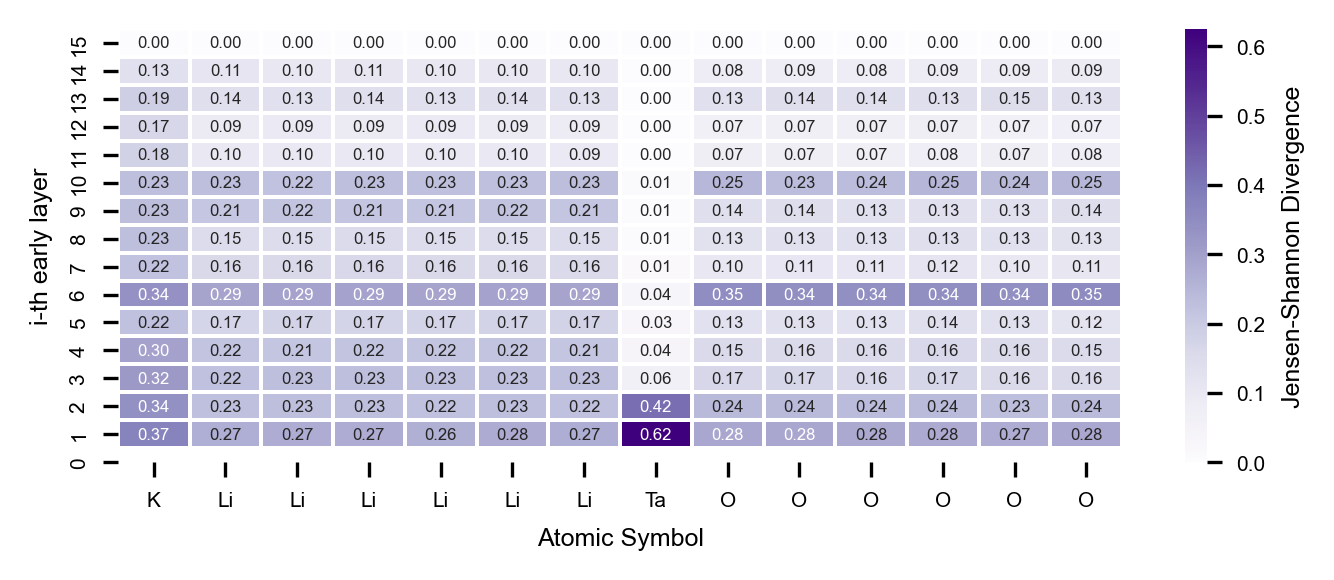

In [14]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import matplotlib.pyplot as plt
import matplotlib as mpl
# Arial 7pt
plt.rc('font', family='Arial', size=5)
mpl.rcParams['figure.dpi'] = 300  # 원하는 DPI 값

jsd = np.array(jsd)

# 컬럼 및 인덱스 라벨 (예제)
atomic_numbers = atoms.get_chemical_symbols()  # 원자 번호
layers = [f"{i}" for i in range(len(feats),-1,-1)]  # Layer indices (내림차순)

# 히트맵 그리기
plt.figure(figsize=(7.2*3/4, 2.5*3/4))
ax = sns.heatmap(jsd[::-1], annot=True, fmt=".2f", cmap="Blues", linewidths=0.5, xticklabels=atomic_numbers, yticklabels=layers, annot_kws={'fontsize': 4})

# 제목 및 라벨 설정
ax.set_xlabel("Atomic Symbol", fontsize=6)
ax.set_ylabel("i-th early layer", fontsize=6)
# Adjust tick label sizes separately
ax.tick_params(axis='x', labelsize=5)  # X-axis tick labels
ax.tick_params(axis='y', labelsize=5)  # Y-axis tick labels
# Add colorbar label on the right
cbar = ax.collections[0].colorbar
cbar.ax.set_ylabel("Jensen-Shannon Divergence", fontsize=6)  # Colorbar label and font size

# plt.title("JSD Heatmap Across Layers and Atoms")
plt.savefig('JSD_KLi6TaO6.png', transparent=True)


In [ ]:
atoms = smiles_to_ase('CN1C=NC2=C1C(=O)N(C(=O)N2C)C')

In [7]:
from rdkit.Chem.Draw import rdMolDraw2D
  

mol = Chem.MolFromSmiles('CN1C=NC2=C1C(=O)N(C(=O)N2C)C')
# Add hydrogen atoms
# mol = Chem.AddHs(mol)

# Generate a 3D conformation using ETKDG_v3
AllChem.EmbedMolecule(mol, maxAttempts=10)
AllChem.UFFOptimizeMolecule(mol, maxIters=100)

drawer = rdMolDraw2D.MolDraw2DSVG(900, 900)
opts = drawer.drawOptions()
opts.useBWAtomPalette()        # ★ 흑백 팔레트 사용
# (선 너비 등 추가 설정 원하면 opts.bondLineWidth = 1.5 같이 지정)
drawer.DrawMolecule(mol)
drawer.FinishDrawing()
svg_data = drawer.GetDrawingText()

with open(f"caffeine.svg","w") as f:
    f.write(svg_data)

[12:14:58] Molecule does not have explicit Hs. Consider calling AddHs()
[12:14:58] Molecule does not have explicit Hs. Consider calling AddHs()


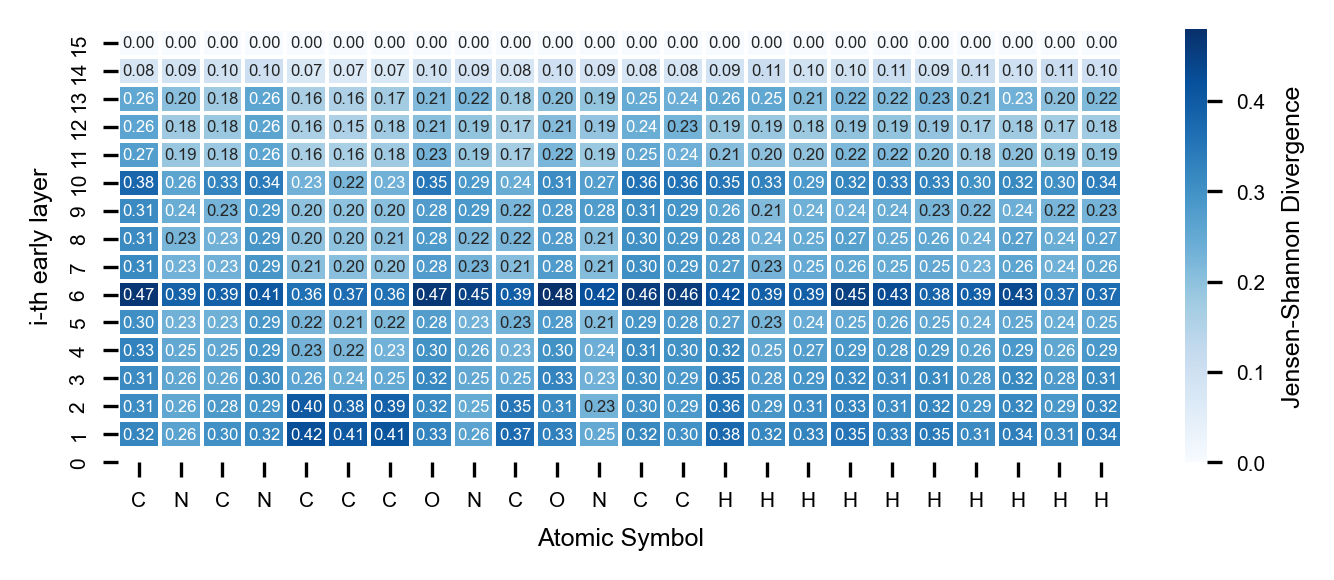

In [9]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import matplotlib.pyplot as plt
import matplotlib as mpl
# Arial 7pt
plt.rc('font', family='Arial', size=5)
mpl.rcParams['figure.dpi'] = 300  # 원하는 DPI 값

jsd = np.array(jsd)

# 컬럼 및 인덱스 라벨 (예제)
atomic_numbers = atoms.get_chemical_symbols()  # 원자 번호
layers = [f"{i}" for i in range(len(feats),-1,-1)]  # Layer indices (내림차순)

# 히트맵 그리기
plt.figure(figsize=(7.2*3/4, 2.5*3/4))
ax = sns.heatmap(jsd[::-1], annot=True, fmt=".2f", cmap="Blues", linewidths=0.5, xticklabels=atomic_numbers, yticklabels=layers, annot_kws={'fontsize': 4})

# 제목 및 라벨 설정
ax.set_xlabel("Atomic Symbol", fontsize=6)
ax.set_ylabel("i-th early layer", fontsize=6)
# Adjust tick label sizes separately
ax.tick_params(axis='x', labelsize=5)  # X-axis tick labels
ax.tick_params(axis='y', labelsize=5)  # Y-axis tick labels
# Add colorbar label on the right
cbar = ax.collections[0].colorbar
cbar.ax.set_ylabel("Jensen-Shannon Divergence", fontsize=6)  # Colorbar label and font size

# plt.title("JSD Heatmap Across Layers and Atoms")
plt.savefig('JSD_molecule.png', transparent=True)


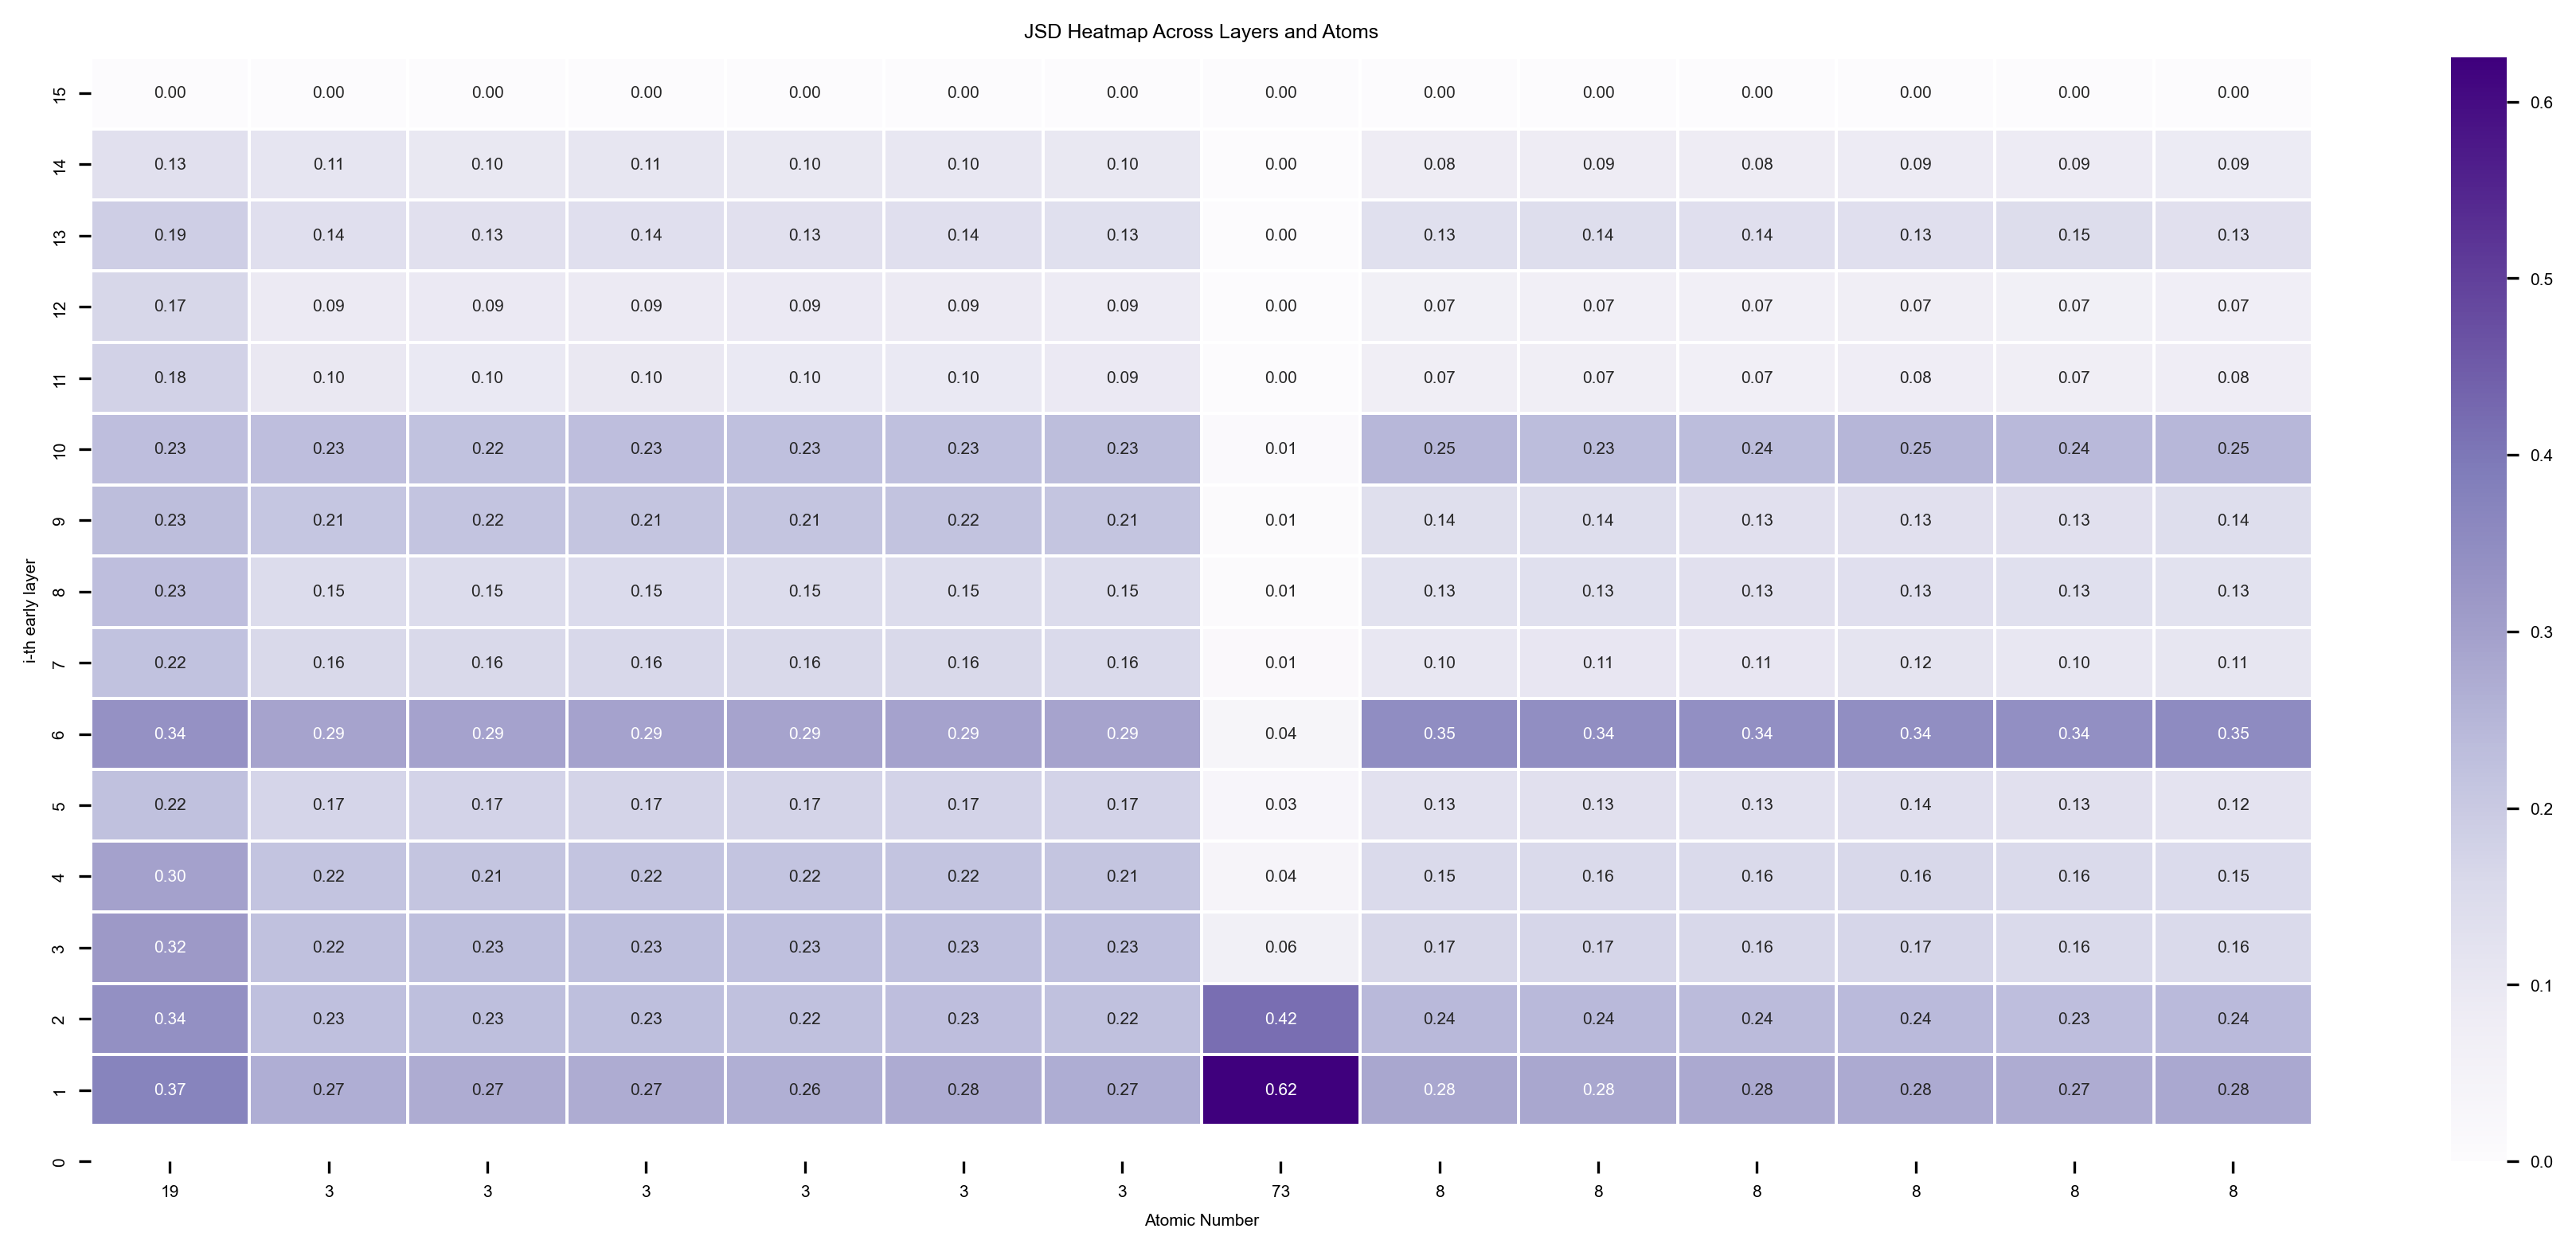

In [9]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import matplotlib.pyplot as plt
import matplotlib as mpl
# Arial 7pt
plt.rc('font', family='Arial', size=5)
mpl.rcParams['figure.dpi'] = 300  # 원하는 DPI 값

jsd = np.array(jsd)

# 컬럼 및 인덱스 라벨 (예제)
atomic_numbers = atoms.get_chemical_symbols()  # 원자 번호
layers = [f"{i}" for i in range(len(feats),-1,-1)]  # Layer indices (내림차순)

# 히트맵 그리기
plt.figure(figsize=(7.2, 3.6))
ax = sns.heatmap(jsd[::-1], annot=True, fmt=".2f", cmap="Purples", linewidths=0.5, xticklabels=atomic_numbers, yticklabels=layers)

# 제목 및 라벨 설정
plt.xlabel("Atomic Symbol")
plt.ylabel("i-th early layer")
# plt.title("JSD Heatmap Across Layers and Atoms")



In [65]:
#visualze atoms

from ase.visualize import view

view(atoms, viewer='x3d')

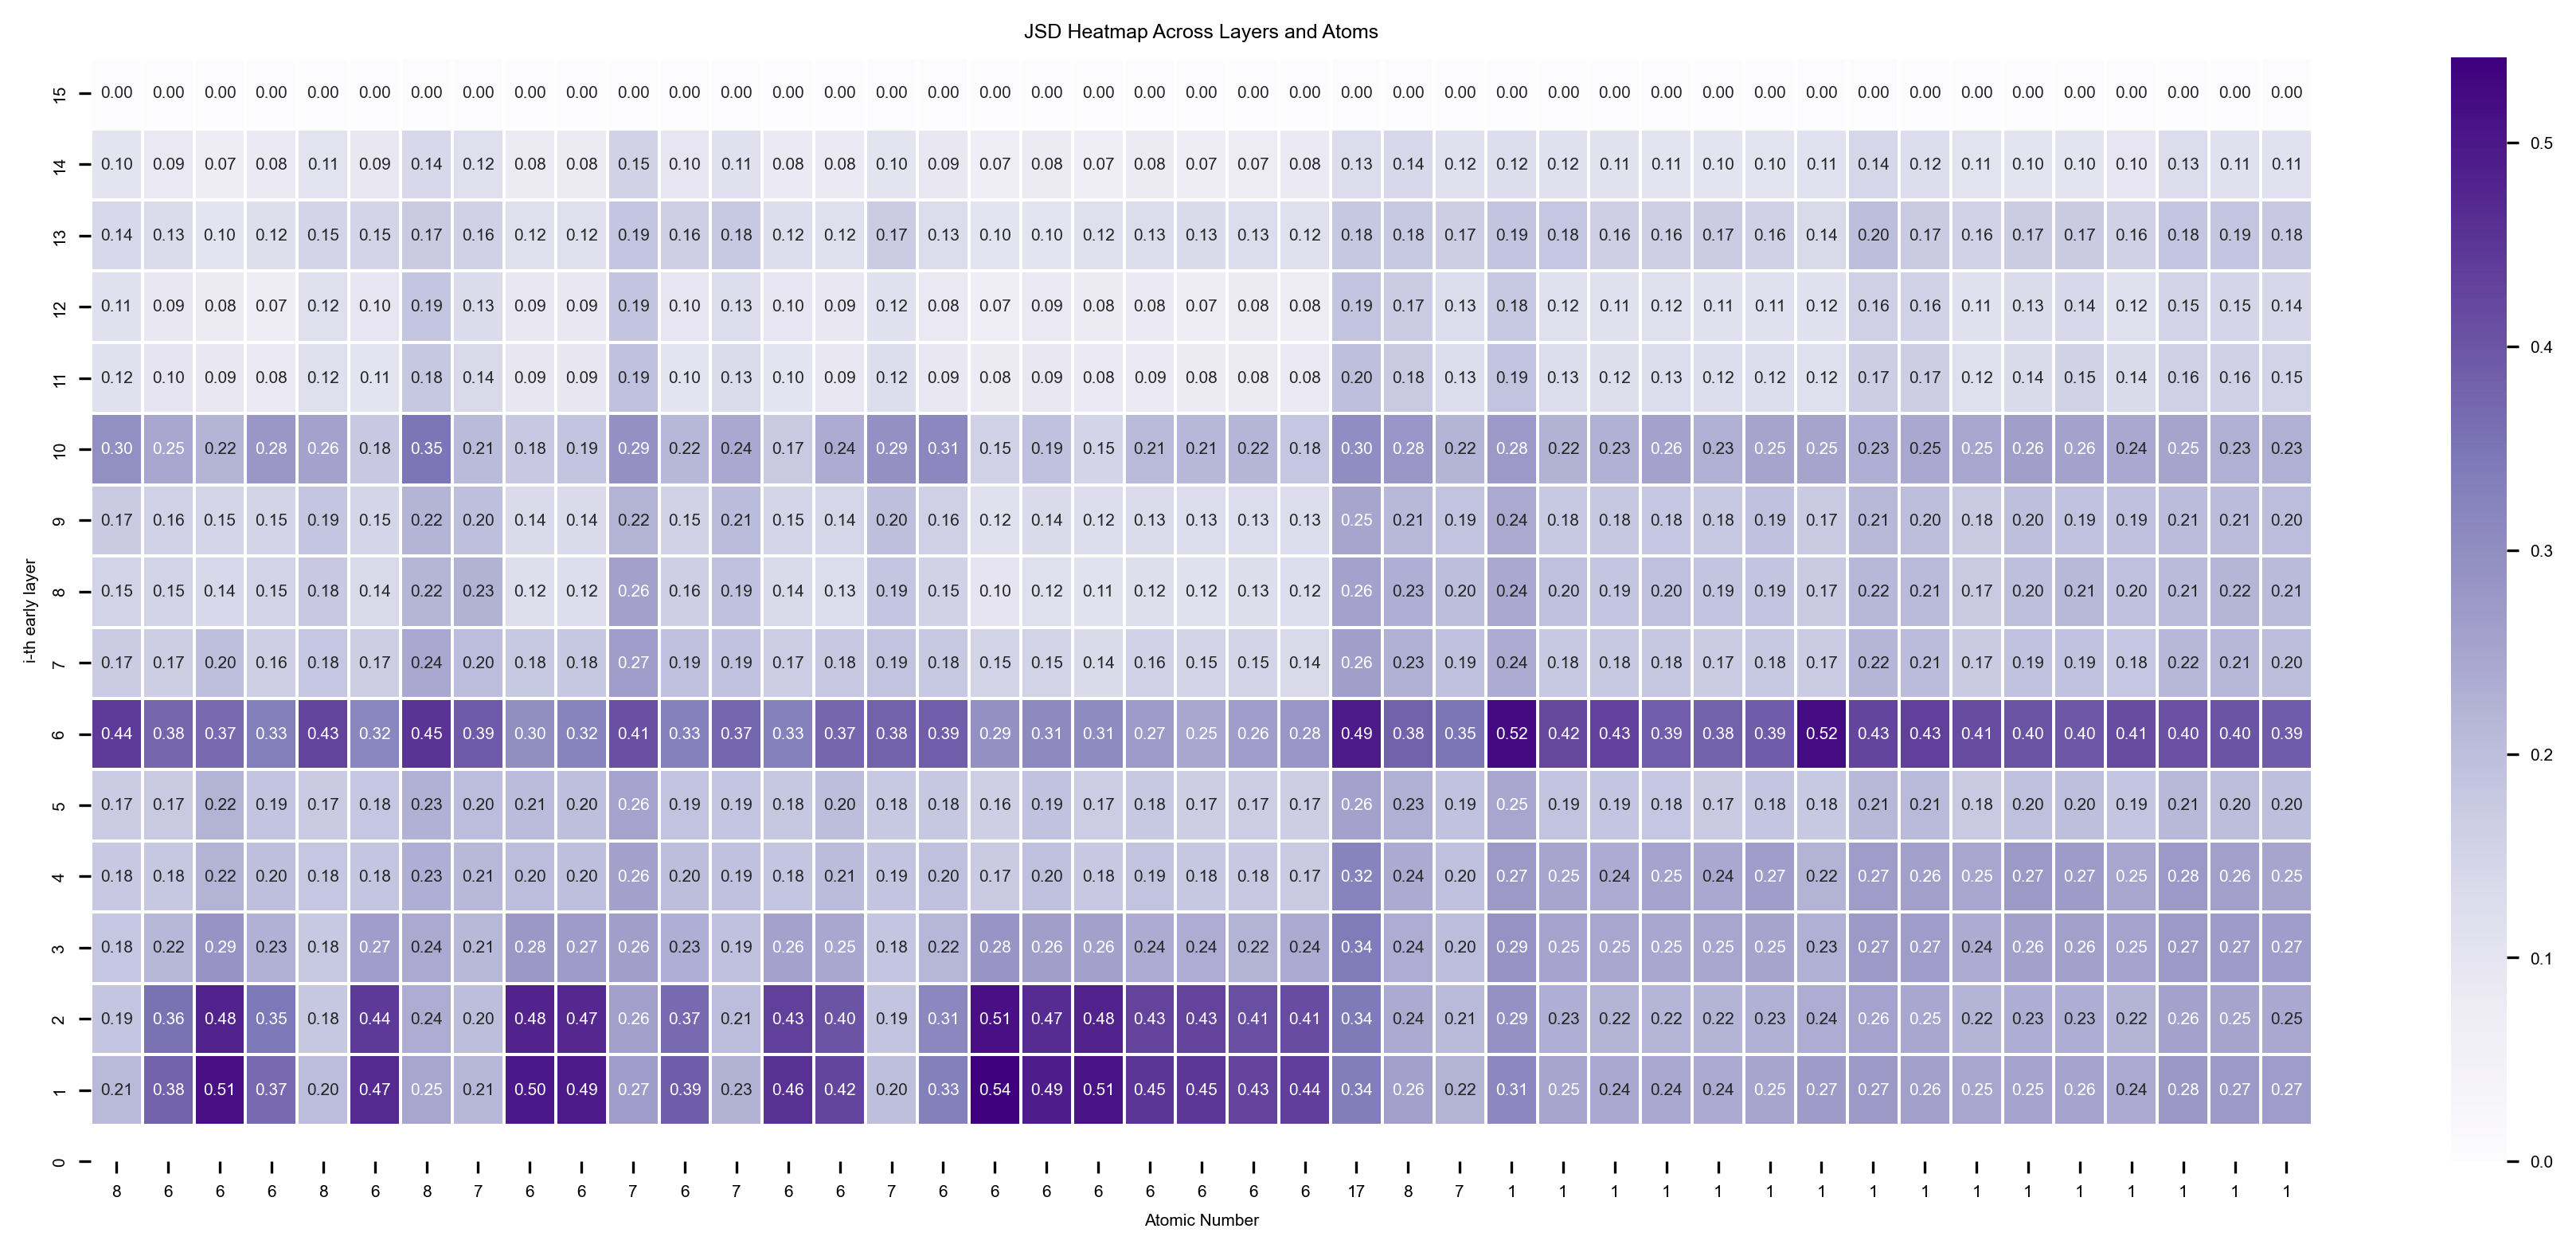

In [62]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import matplotlib.pyplot as plt
import matplotlib as mpl
# Arial 7pt
plt.rc('font', family='Arial', size=5)
mpl.rcParams['figure.dpi'] = 300  # 원하는 DPI 값

jsd = np.array(jsd)

# 컬럼 및 인덱스 라벨 (예제)
atomic_numbers = atoms.get_atomic_numbers()  # 원자 번호
layers = [f"{i}" for i in range(len(feats),-1,-1)]  # Layer indices (내림차순)

# 히트맵 그리기
plt.figure(figsize=(15, 6))
ax = sns.heatmap(jsd[::-1], annot=True, fmt=".2f", cmap="Purples", linewidths=0.5, xticklabels=atomic_numbers, yticklabels=layers)

# 제목 및 라벨 설정
plt.xlabel("Atomic Number")
plt.ylabel("i-th early layer")
plt.title("JSD Heatmap Across Layers and Atoms")

plt.show()


In [63]:
#visualze atoms

from ase.visualize import view

view(atoms, viewer='x3d')

In [25]:
feats = torch.stack(feats)
feats.shape

torch.Size([15, 41, 256])

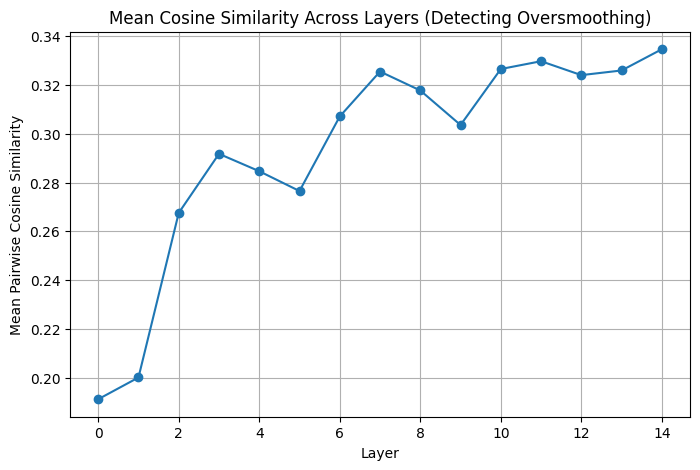

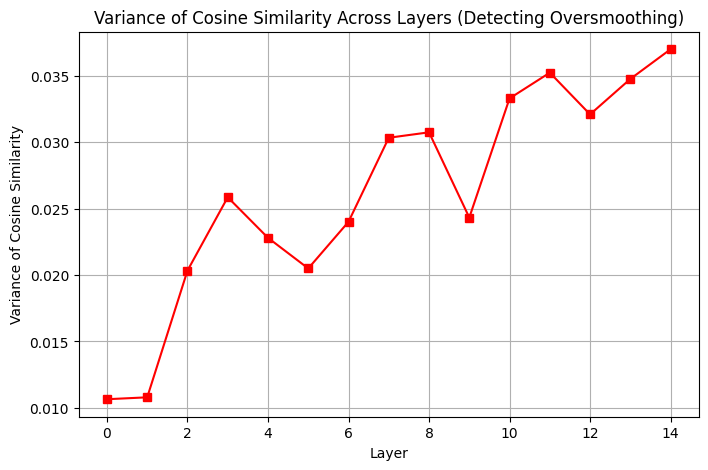

    Layer  Mean Cosine Similarity  Variance of Cosine Similarity
0       0                0.191135                       0.010647
1       1                0.200045                       0.010790
2       2                0.267529                       0.020336
3       3                0.291760                       0.025860
4       4                0.284630                       0.022803
5       5                0.276506                       0.020497
6       6                0.307094                       0.024011
7       7                0.325508                       0.030340
8       8                0.317749                       0.030750
9       9                0.303580                       0.024326
10     10                0.326542                       0.033305
11     11                0.329738                       0.035242
12     12                0.324035                       0.032100
13     13                0.325944                       0.034769
14     14                

In [36]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import cosine_similarity
import pandas as pd

# Load your embeddings (shape: [15 layers, 41 atoms, 256 dimensions])
# embeddings = torch.load("your_embedding_tensor.pt")  # Load if available
torch.manual_seed(42)
embeddings = feats

num_layers, num_atoms, embed_dim = embeddings.shape
mean_cosine_sim_per_layer = []
var_cosine_sim_per_layer = []

for layer in range(num_layers):
    layer_embeddings = embeddings[layer].numpy()  # Convert to numpy
    # cos_sim_matrix = cosine_similarity(layer_embeddings)  # (41 x 41)
    cos_sim_matrix = jsd_torch(torch.tensor(layer_embeddings).reshape(-1,1,256), torch.tensor(layer_embeddings).reshape(1,-1,256)).numpy()
    upper_tri_vals = cos_sim_matrix[np.triu_indices(num_atoms, k=1)]  # Extract upper triangle

    mean_cosine_sim_per_layer.append(np.mean(upper_tri_vals))
    var_cosine_sim_per_layer.append(np.var(upper_tri_vals))

# Convert to DataFrame
cosine_sim_stats = pd.DataFrame({
    "Layer": np.arange(num_layers),
    "Mean Cosine Similarity": mean_cosine_sim_per_layer,
    "Variance of Cosine Similarity": var_cosine_sim_per_layer
})

# Plot Mean Cosine Similarity
plt.figure(figsize=(8, 5))
plt.plot(cosine_sim_stats["Layer"], cosine_sim_stats["Mean Cosine Similarity"], marker='o', linestyle='-')
plt.xlabel("Layer")
plt.ylabel("Mean Pairwise Cosine Similarity")
plt.title("Mean Cosine Similarity Across Layers (Detecting Oversmoothing)")
plt.grid()
plt.show()

# Plot Variance of Cosine Similarity
plt.figure(figsize=(8, 5))
plt.plot(cosine_sim_stats["Layer"], cosine_sim_stats["Variance of Cosine Similarity"], marker='s', linestyle='-', color='red')
plt.xlabel("Layer")
plt.ylabel("Variance of Cosine Similarity")
plt.title("Variance of Cosine Similarity Across Layers (Detecting Oversmoothing)")
plt.grid()
plt.show()

# Display computed statistics
print(cosine_sim_stats)


In [33]:
# add dim in 1
layer_embeddings

array([[ 0.9653839 , -0.32533145,  0.02875751, ...,  0.42278576,
        -0.22736177, -2.1080198 ],
       [-0.30301788, -0.10377044,  0.37600178, ...,  0.08818483,
        -0.0101723 ,  0.07084273],
       [-0.07109707,  0.22350398,  0.4266516 , ...,  0.07337236,
        -0.2379176 ,  0.31788966],
       ...,
       [ 0.16803876,  0.19940795, -0.0228571 , ...,  0.92715657,
        -0.2568795 , -0.4214198 ],
       [ 0.12047355,  0.03422177,  0.2845587 , ...,  0.6977694 ,
        -0.23231804, -0.4250471 ],
       [ 0.02459351,  0.19525132, -0.18252526, ...,  0.40092587,
        -0.11224118,  0.16023849]], dtype=float32)

In [ ]:
jsd_torch(torch.tensor(layer_embeddings).reshape(-1,1,256), torch.tensor(layer_embeddings).reshape(1,-1,256))

torch.Size([41, 41])

In [ ]:
mptrj = pd.read_json('/home/lucky/Projects/ion_conductivity/feat/data/MPtrj_2022.9_full.json')

In [ ]:
mptrj

KeyError: 'Structure'

In [46]:
import copy
import types
import torch  # Example using PyTorch decorators

def clone_and_modify(obj, method_name, new_method):
    """
    Clones an object, copies all attributes, and modifies a specific method,
    while preserving decorators if they exist.

    :param obj: The original object
    :param method_name: The name of the method to modify
    :param new_method: The new method function to replace the original one
    :return: A cloned object with modified method
    """
    # 1. Create a new object without calling __init__
    new_obj = obj.__class__.__new__(obj.__class__)  
    new_obj.__dict__ = copy.deepcopy(obj.__dict__)  # Copy attributes

    # 2. Check if method exists
    if hasattr(new_obj, method_name):
        original_method = getattr(new_obj, method_name)

        # 3. Handle decorated functions (check for __wrapped__)
        if hasattr(original_method, "__func__"):  # It's a bound method
            original_func = original_method.__func__
        else:
            original_func = original_method

        if hasattr(original_func, "__wrapped__"):  # If function is wrapped (decorated)
            original_func = original_func.__wrapped__

        # 4. Bind the new function to the object
        modified_function = types.MethodType(new_method, new_obj)

        # 5. Replace method in the new object
        setattr(new_obj, method_name, modified_function)
    
    return new_obj

# === Test Class ===
class OriginalClass:
    def __init__(self, x):
        self.x = x

    @torch.no_grad()  # PyTorch decorator
    def show(self):
        print(f"Original Value: {self.x}")

# Define new method
def modified_show(self):
    print(f"Modified Value: {self.x * 2}")

# Create original object
original_obj = OriginalClass(10)
original_obj.show()  # Original Value: 10 (without gradient)

# Clone object and modify method
cloned_obj = clone_and_modify(original_obj, "show", modified_show)
cloned_obj.show()  # Modified Value: 20 (still no gradient!)


Original Value: 10
Modified Value: 20


In [2]:
from mpl_toolkits.basemap import Basemap
import matplotlib.pyplot as plt

# Create a cylindrical world map
m = Basemap()

# Draw map features
m.drawcoastlines()
m.drawcountries()

plt.title('World Map')
plt.show()


ModuleNotFoundError: No module named 'mpl_toolkits.basemap'

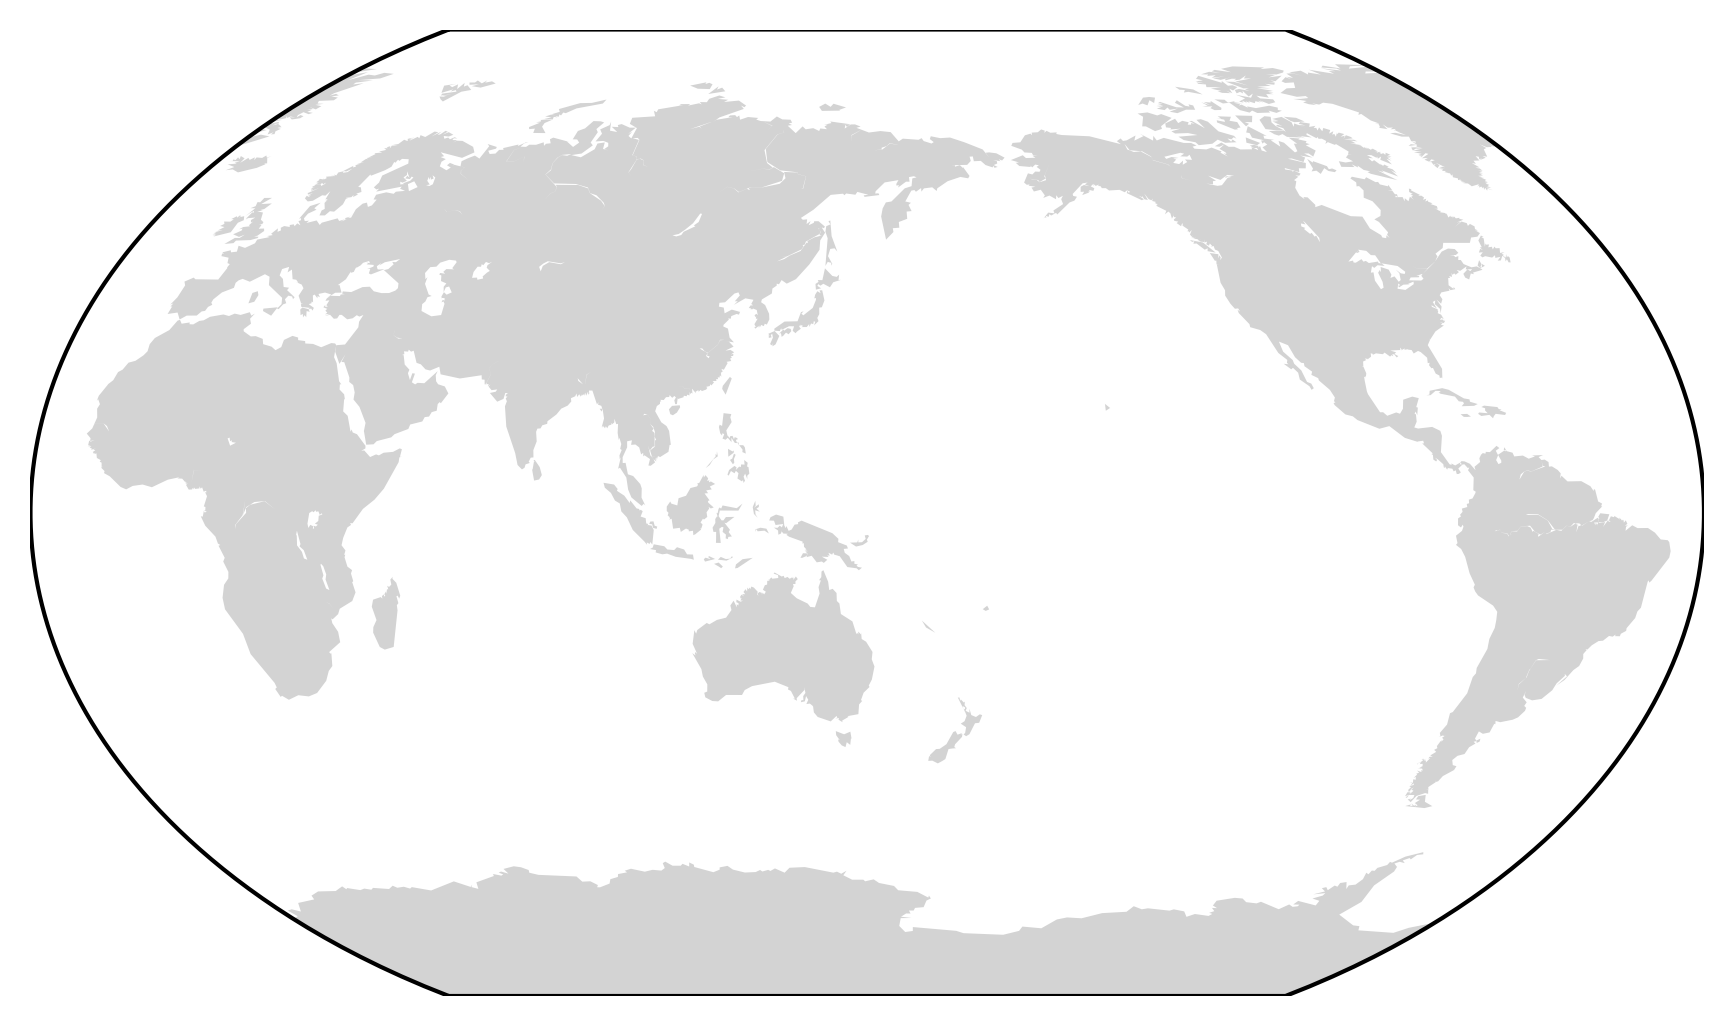

In [13]:
from mpl_toolkits.basemap import Basemap
import matplotlib.pyplot as plt
import matplotlib as mpl


# Arial 7pt
plt.rc('font', family='Arial', size=7)
mpl.rcParams['figure.dpi'] = 300  # 원하는 DPI 값
plt.figure(figsize=(7.2, 4.8))

# Seoul’s coords
seoul_lon, seoul_lat = 126.97, 37.56

# Create a cylindrical map centered on Seoul
m = Basemap(
    projection='kav7',
    lon_0=seoul_lon+25,     # central longitude
    lat_0=seoul_lat,     # central latitude (for vertical centering)
    resolution='c'
)

# Draw features
# m.drawcoastlines()
# m.drawcountries()
# m.drawmapboundary(fill_color='lightblue')
m.fillcontinents(color='lightgray')#, lake_color='lightblue')

# Add a marker for Seoul
x, y = m(seoul_lon, seoul_lat)
# m.plot(x, y, 'ro', markersize=5)
# plt.text(x+2, y-2, 'Seoul', color='red')

# plt.title('World Map Centered on Seoul')
plt.show()


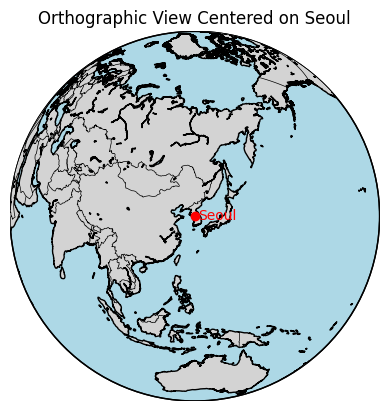

In [3]:
from mpl_toolkits.basemap import Basemap
import matplotlib.pyplot as plt

seoul_lon, seoul_lat = 126.97, 37.56

m = Basemap(
    projection='ortho',
    lon_0=seoul_lon,
    lat_0=seoul_lat,
    resolution='l'
)

m.drawcoastlines()
m.drawcountries()
m.drawmapboundary(fill_color='lightblue')
m.fillcontinents(color='lightgray', lake_color='lightblue')

# Mark Seoul
x, y = m(seoul_lon, seoul_lat)
m.plot(x, y, 'ro', markersize=6)
plt.text(x+100000, y-100000, 'Seoul', color='red')

plt.title('Orthographic View Centered on Seoul')
plt.show()
